## Постановка задачи и исходные данные
* **Цель**: Построить алгоритм прогнозирования суммарных продаж (онлайн + офлайн) на одну неделю вперёд для тестового периода (сентябрь 2024 года). Прогнозирование проводится только для тех дат тестовой выборки, чтобы можно было оценить метрики.
* **Ограничение по товарам**: Прогнозируемые товары – это только те, которые присутствуют в файле actual_matrix.csv (матрица товаров).
* **Исходные данные**: Имеются несколько файлов:
     * sales.csv – офлайн продажи по магазинам;
     * online.csv – онлайн продажи;
     * markdowns.csv – данные о продажах по сниженным ценам;
     * price_history.csv – история изменения цен;
     * discounts_history.csv – история акций и промо-акций;
     * catalog.csv – характеристики товаров;
     * stores.csv – информация о магазинах.

Каждый набор данных может внести дополнительные признаки, влияющие на спрос, такие как цена, скидки, промоакции и сезонные факторы.

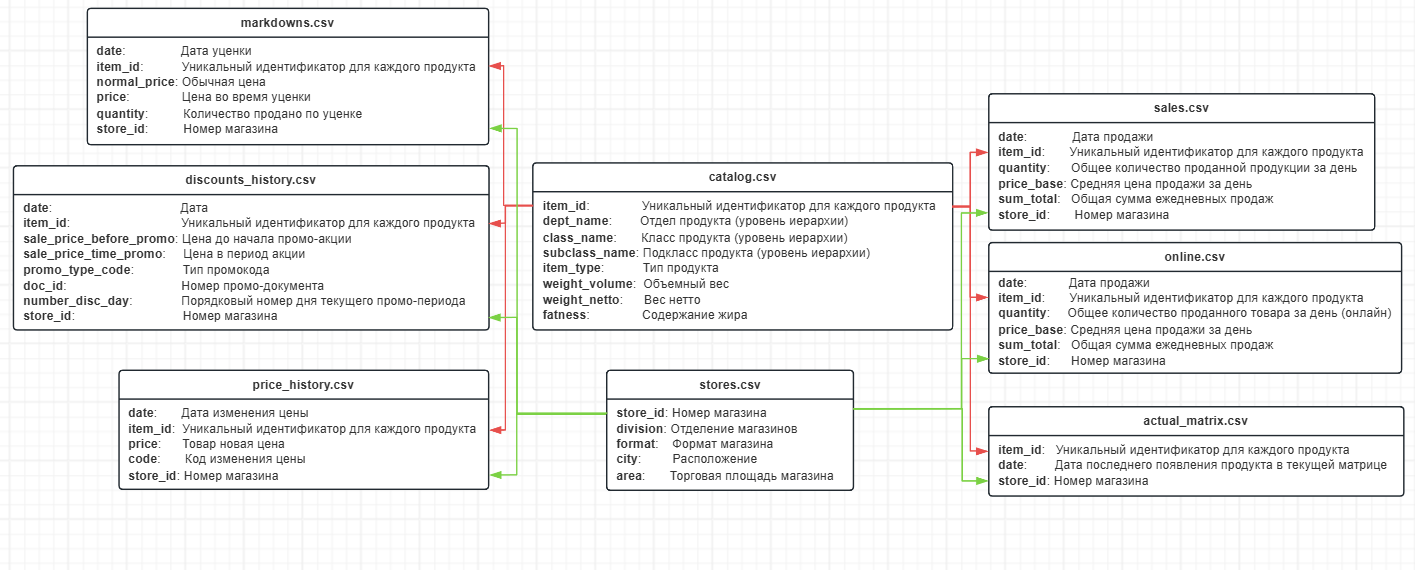

In [2]:
import os
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style, init
import phik
from phik import resources, report
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import GridSearchCV, ParameterGrid
from catboost import CatBoostRegressor, Pool
from pmdarima import auto_arima


pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
local_path = r"C:\Users\dinos\Downloads\archive"

files = [
    "sales.csv",
    "stores.csv",
    "actual_matrix.csv",
    "catalog.csv",
    "discounts_history.csv",
    "markdowns.csv",
    "online.csv",
    "price_history.csv"
]

In [4]:
def load_file(file_name, local_path, parse_dates=None):
    local_file_path = os.path.join(local_path, file_name)
    
    if os.path.exists(local_file_path):
        print(f"Loading {file_name} from local directory...")
        return pd.read_csv(local_file_path, parse_dates=parse_dates)
    else:
        print(f"{file_name} not found locally. Downloading from Kaggle...")
        path = kagglehub.dataset_download("svizor/retail-sales-forecasting-data")
        kaggle_file_path = os.path.join(path, file_name)
        
        if os.path.exists(kaggle_file_path):
            return pd.read_csv(kaggle_file_path, parse_dates=parse_dates)
        else:
            raise FileNotFoundError(f"Failed to find {file_name} in both local directory and Kaggle dataset.")


In [5]:
sales = load_file("sales.csv", local_path, parse_dates=['date'])
stores = load_file("stores.csv", local_path)
actual_matrix = load_file("actual_matrix.csv", local_path, parse_dates=['date'])
catalog = load_file("catalog.csv", local_path)
discounts_history = load_file("discounts_history.csv", local_path, parse_dates=['date'])
markdowns = load_file("markdowns.csv", local_path, parse_dates=['date'])
online = load_file("online.csv", local_path, parse_dates=['date'])
price_history = load_file("price_history.csv", local_path, parse_dates=['date'])

Loading sales.csv from local directory...
Loading stores.csv from local directory...
Loading actual_matrix.csv from local directory...
Loading catalog.csv from local directory...
Loading discounts_history.csv from local directory...
Loading markdowns.csv from local directory...
Loading online.csv from local directory...
Loading price_history.csv from local directory...


In [6]:
data = {
    'sales': sales,
    'stores': stores,
    'actual_matrix': actual_matrix,
    'catalog': catalog,
    'discounts_history': discounts_history,
    'markdowns': markdowns,
    'online': online,
    'price_history': price_history
}

In [7]:
for name, df in data.items():
    print(f'\033[33mДатафрейм: {name}\033[0m') 
    display(df.head())
    display(df.info())
    print(df.isnull().sum())

Датафрейм: sales


,Unnamed: 0,date,item_id,quantity,price_base,sum_total,store_id
0,0,2023-08-04,293375605257,1.00,47.86,47.86,1
1,1,2023-08-04,a66fdf2c0ae7,3.00,49.60,148.80,1
2,2,2023-08-04,daa46ef49b7a,0.82,379.00,311.54,1
3,3,2023-08-04,a3b49c1bf758,1.00,129.00,129.00,1
4,4,2023-08-04,ab611c5cef62,7.00,79.90,559.30,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7432685 entries, 0 to 7432684
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Unnamed: 0  int64         
 1   date        datetime64[ns]
 2   item_id     object        
 3   quantity    float64       
 4   price_base  float64       
 5   sum_total   float64       
 6   store_id    int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 396.9+ MB


None

Unnamed: 0    0
date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64
Датафрейм: stores


,Unnamed: 0,store_id,division,format,city,area
0,0,4,Div1,MaxiEuro,City3,1887
1,1,3,Div2,Format-7 express,City2,109
2,2,2,Div2,Format-6,City1,210
3,3,1,Div1,Format-1,City1,1500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4 non-null      int64 
 1   store_id    4 non-null      int64 
 2   division    4 non-null      object
 3   format      4 non-null      object
 4   city        4 non-null      object
 5   area        4 non-null      int64 
dtypes: int64(3), object(3)
memory usage: 320.0+ bytes


None

Unnamed: 0    0
store_id      0
division      0
format        0
city          0
area          0
dtype: int64
Датафрейм: actual_matrix


,Unnamed: 0,item_id,date,store_id
0,0,c578da8e8841,2019-10-17,1
1,1,4dd2b686802c,2019-10-17,1
2,2,16ade2e3fca9,2019-10-17,1
3,3,f4eb16dab09e,2019-10-17,1
4,4,ab1384c2af6d,2020-05-31,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35202 entries, 0 to 35201
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  35202 non-null  int64         
 1   item_id     35202 non-null  object        
 2   date        35202 non-null  datetime64[ns]
 3   store_id    35202 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.1+ MB


None

Unnamed: 0    0
item_id       0
date          0
store_id      0
dtype: int64
Датафрейм: catalog


,Unnamed: 0,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
0,0,da17e2d5feda,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,БУМАЖНАЯ ПРОДУКЦИЯ,ВЛАЖНЫЕ САЛФЕТКИ,NaN,150.00,NaN,NaN
1,1,614de2b96018,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,30.00,NaN,NaN
2,2,0c1f1f3e3e11,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,NaN,NaN,NaN
3,3,71a7fa99f005,ТОВАРЫ ДЛЯ ДОМА,ПОСУДА,КУХОННАЯ ПОСУДА,NaN,NaN,NaN,NaN
4,4,ec1bd4d59fe9,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,30.00,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219810 entries, 0 to 219809
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     219810 non-null  int64  
 1   item_id        219810 non-null  object 
 2   dept_name      219810 non-null  object 
 3   class_name     219810 non-null  object 
 4   subclass_name  219810 non-null  object 
 5   item_type      43586 non-null   object 
 6   weight_volume  82952 non-null   float64
 7   weight_netto   48957 non-null   float64
 8   fatness        7212 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 15.1+ MB


None

Unnamed: 0            0
item_id               0
dept_name             0
class_name            0
subclass_name         0
item_type        176224
weight_volume    136858
weight_netto     170853
fatness          212598
dtype: int64
Датафрейм: discounts_history


,Unnamed: 0,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
0,3648316,2022-08-28,cde97a9ec3ef,729.90,669.90,6.00,89ea9f0c-1c08-11ed-ad4d-005056861040,13.00,1
1,3648317,2022-08-28,2906fbc9e11c,129.90,99.90,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.00,1
2,3648318,2022-08-28,c48c3a3d8c01,129.90,99.90,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.00,1
3,3648319,2022-08-28,f85243ca61e6,129.90,99.90,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.00,1
4,3648320,2022-08-28,27ce75534065,129.90,99.90,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.00,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3746744 entries, 0 to 3746743
Data columns (total 9 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   Unnamed: 0               int64         
 1   date                     datetime64[ns]
 2   item_id                  object        
 3   sale_price_before_promo  float64       
 4   sale_price_time_promo    float64       
 5   promo_type_code          float64       
 6   doc_id                   object        
 7   number_disc_day          float64       
 8   store_id                 int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 257.3+ MB


None

Unnamed: 0                      0
date                            0
item_id                         0
sale_price_before_promo         0
sale_price_time_promo           0
promo_type_code            317846
doc_id                          0
number_disc_day                 0
store_id                        0
dtype: int64
Датафрейм: markdowns


,Unnamed: 0,date,item_id,normal_price,price,quantity,store_id
0,0,2023-08-01,bc2f82a22e11,189.00,100.00,8.00,1
1,1,2023-08-01,389412076801,179.00,100.00,5.00,1
2,2,2023-08-01,0e39cf5d57c1,149.00,100.00,5.00,1
3,3,2023-08-01,dd94e2bc5601,149.00,100.00,1.00,1
4,4,2023-08-01,e60d890f2812,369.00,270.00,1.00,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8979 entries, 0 to 8978
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    8979 non-null   int64         
 1   date          8979 non-null   datetime64[ns]
 2   item_id       8979 non-null   object        
 3   normal_price  8979 non-null   float64       
 4   price         8979 non-null   float64       
 5   quantity      8979 non-null   float64       
 6   store_id      8979 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 491.2+ KB


None

Unnamed: 0      0
date            0
item_id         0
normal_price    0
price           0
quantity        0
store_id        0
dtype: int64
Датафрейм: online


,Unnamed: 0,date,item_id,quantity,price_base,sum_total,store_id
0,0,2023-08-04,4aa8dbe05246,3.00,12.40,37.21,1
1,1,2023-08-04,4e0fbcf99cf9,2.00,56.27,112.54,1
2,2,2023-08-04,2e008b673129,2.00,56.27,112.54,1
3,3,2023-08-04,49db9c973903,1.00,29.94,29.94,1
4,4,2023-08-04,9d6072422e8e,1.00,80.10,80.10,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1123412 entries, 0 to 1123411
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Unnamed: 0  1123412 non-null  int64         
 1   date        1123412 non-null  datetime64[ns]
 2   item_id     1123412 non-null  object        
 3   quantity    1123412 non-null  float64       
 4   price_base  1123412 non-null  float64       
 5   sum_total   1123412 non-null  float64       
 6   store_id    1123412 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 60.0+ MB


None

Unnamed: 0    0
date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64
Датафрейм: price_history


,Unnamed: 0,date,item_id,price,code,store_id
0,0,2023-08-01,4a1f95fe4d4b,499.90,1,1
1,1,2023-08-01,bf43a9d3ae13,0.00,9999999999,1
2,2,2023-08-01,0dd8744decce,129.90,1,1
3,3,2023-08-01,9b38c7e4dba9,136.00,1,1
4,4,2023-08-01,b791e8c9347c,0.00,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698626 entries, 0 to 698625
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Unnamed: 0  698626 non-null  int64         
 1   date        698626 non-null  datetime64[ns]
 2   item_id     698626 non-null  object        
 3   price       698626 non-null  float64       
 4   code        698626 non-null  int64         
 5   store_id    698626 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 32.0+ MB


None

Unnamed: 0    0
date          0
item_id       0
price         0
code          0
store_id      0
dtype: int64


Датасеты имеют следующие особенности:
* Столбцы Unnamed: 0 во всех датафреймах не несут смысловой нагрузки и могут быть удалены.
*  Имеються пропуски в "catalog" и "discounts_history"

## Предобработка

In [8]:
for name, df in data.items():
        df.drop(columns='Unnamed: 0', inplace=True)

In [9]:
actual_matrix.head()

,item_id,date,store_id
0,c578da8e8841,2019-10-17,1
1,4dd2b686802c,2019-10-17,1
2,16ade2e3fca9,2019-10-17,1
3,f4eb16dab09e,2019-10-17,1
4,ab1384c2af6d,2020-05-31,1


In [10]:
for name, df in data.items():
    duplicates = df[df.duplicated()]
    num_duplicates = len(duplicates)
    if num_duplicates > 0:
        print(Fore.RED + f"Дубликаты в {name} ({num_duplicates} шт.):")
        print(duplicates)
    else:
        print(Fore.GREEN + f"Дубликатов в {name} не найдено.")

Дубликатов в sales не найдено.
Дубликатов в stores не найдено.
Дубликатов в actual_matrix не найдено.
Дубликатов в catalog не найдено.
Дубликатов в discounts_history не найдено.
Дубликаты в markdowns (268 шт.):
           date       item_id  normal_price  price  quantity  store_id
3737 2023-08-02  0e39cf5d57c1        149.00 100.00      3.00         1
3738 2023-08-02  fb45888e228e        589.00 350.00      6.00         1
3748 2023-08-01  bc2f82a22e11        189.00 100.00      8.00         1
3749 2023-08-01  389412076801        179.00 100.00      5.00         1
3750 2023-08-01  0e39cf5d57c1        149.00 100.00      5.00         1
...         ...           ...           ...    ...       ...       ...
7456 2023-08-17  44dba4d4d441        309.00 182.40      1.00         2
7457 2023-08-17  aeeec4788cf5        359.00 230.00      2.00         2
7458 2023-08-17  d6467e3c8762        399.00 257.20      1.00         2
7459 2023-08-17  8692ad0cb38d        599.00 400.00      3.00         2
7460 202

Позже обработаем дубликаты

### sales

In [11]:
def analyze_sales(dataframe):
    print("Описательная статистика:")
    print(dataframe.describe())

    print("\nГистограммы распределения:")
    dataframe.hist(grid=True, figsize=(19, 10), bins=30)
    plt.tight_layout()
    plt.show()

Описательная статистика:
        quantity  price_base  sum_total   store_id
count 7432685.00  7432685.00 7432685.00 7432685.00
mean        5.64      207.58     761.28       2.04
std        27.40      337.29    4789.48       1.21
min      -500.00   -21676.67  -20410.80       1.00
25%         1.00       60.00     127.90       1.00
50%         2.00      109.90     259.60       2.00
75%         4.67      199.90     599.00       3.00
max      4952.00    28999.90  686524.21       4.00

Гистограммы распределения:


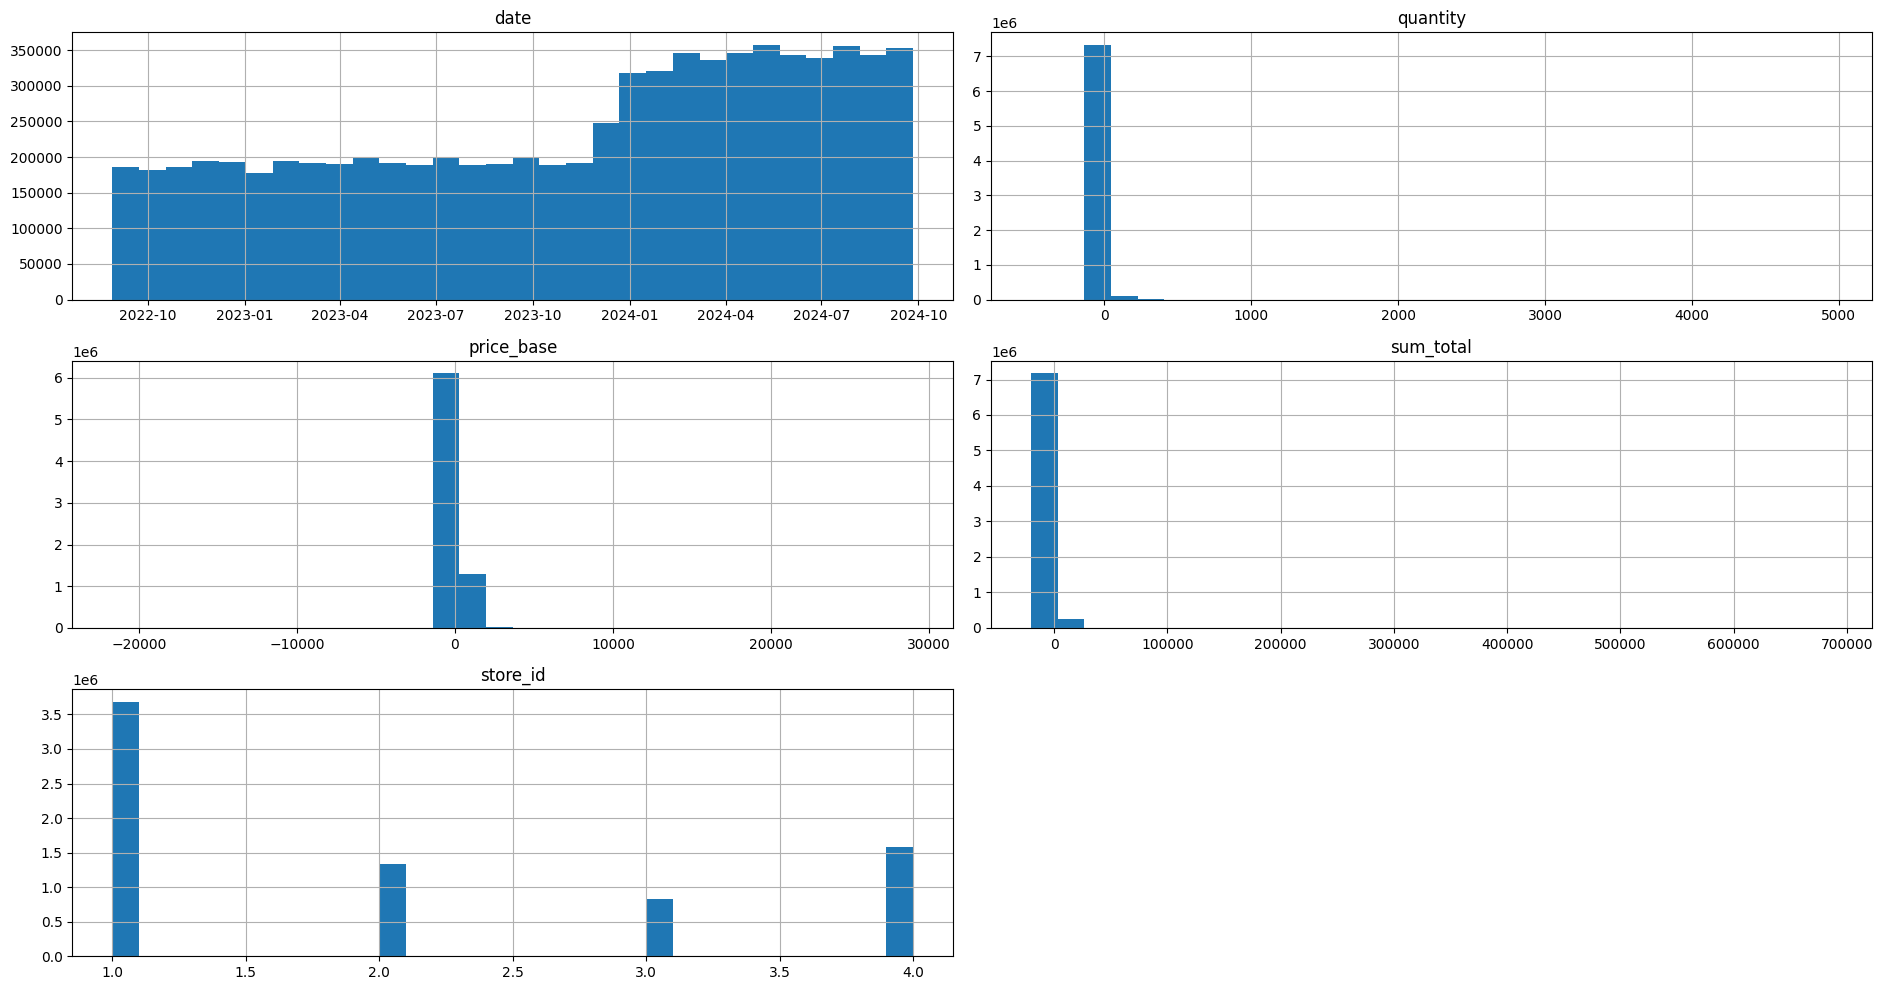

In [12]:
analyze_sales(sales)

#### quantity

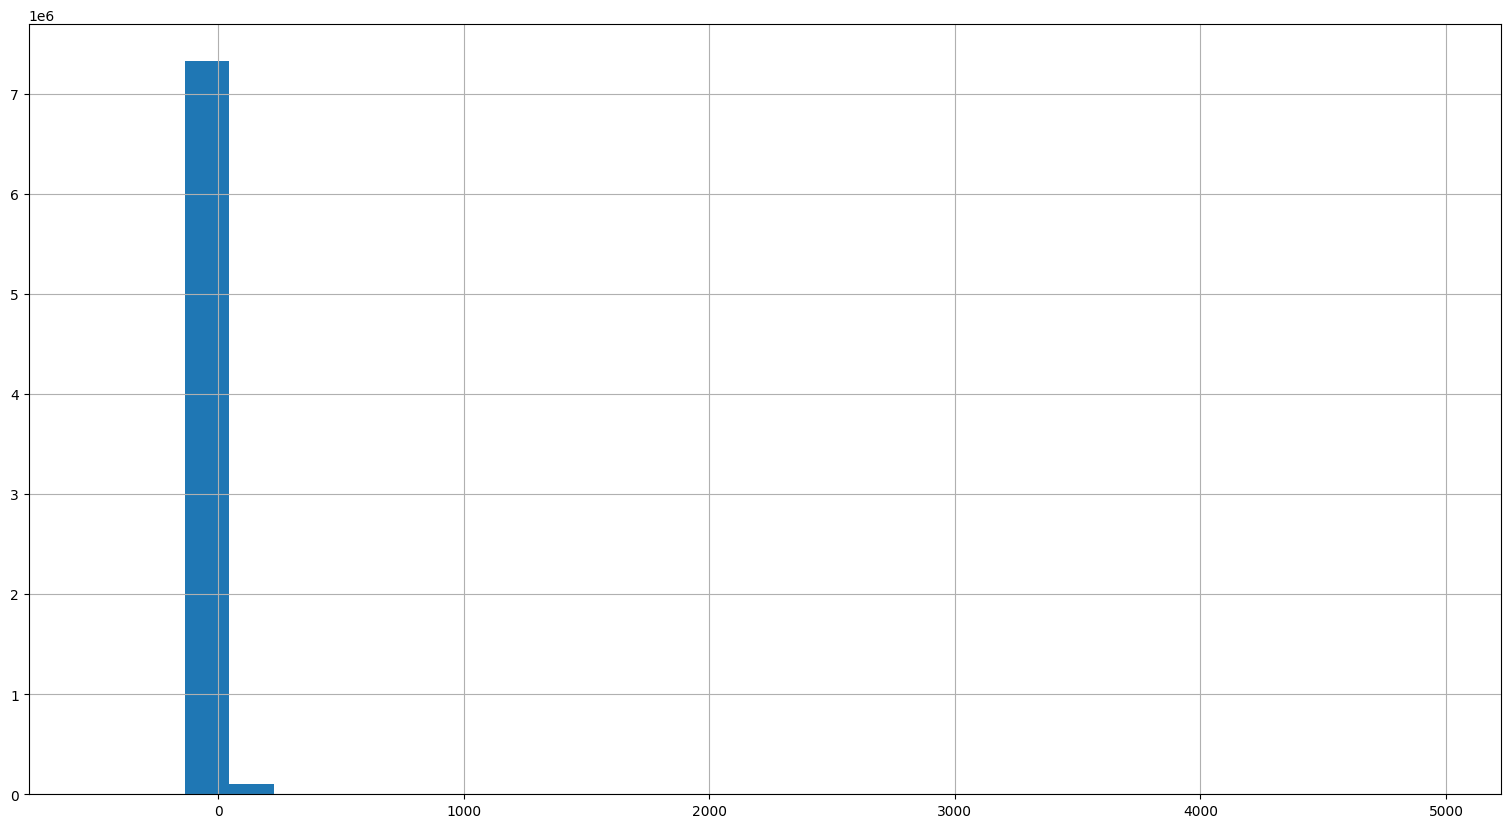

In [13]:
sales['quantity'].hist(grid=True, figsize=(19, 10), bins=30);

In [14]:
sales[sales['quantity'] > 1000]

,date,item_id,quantity,price_base,sum_total,store_id
1561,2023-08-04,b0d24502fb66,1916.00,6.94,13287.84,1
7734,2023-08-07,b0d24502fb66,1494.00,6.89,10292.64,1
11735,2023-08-08,b0d24502fb66,1360.00,6.92,9406.80,1
15364,2023-08-09,b0d24502fb66,1370.00,6.91,9465.98,1
20941,2023-08-15,b0d24502fb66,1404.00,6.92,9720.92,1
...,...,...,...,...,...,...
7421135,2024-09-24,327c5bc1e583,2236.00,0.01,19.24,4
7423839,2024-09-25,b0d24502fb66,1494.00,7.89,11791.05,4
7426325,2024-09-25,327c5bc1e583,3761.00,0.01,32.14,4
7429113,2024-09-26,b0d24502fb66,1592.00,7.90,12581.03,4


In [15]:
sales[sales['quantity'] > 1000].value_counts('item_id')

item_id
b0d24502fb66    1045
327c5bc1e583      50
0a1b39cd6988      20
6d284b4e9982       6
81e546c3ac97       5
9a7e315f3f42       4
aba951017adf       3
63161948a95a       3
5b8e114fdf6f       2
6e483c76cdec       1
b8dbc0c80600       1
66d8af1bb147       1
0b82cdc4e5c6       1
559ad411ccbb       1
2e58990eaa3c       1
21de7c0cffe8       1
21b8dfbd361a       1
fdab1df498e8       1
dtype: int64

Имеються много кол-ва продаж связанных с b0d24502fb66 и 327c5bc1e583. Проверим их

In [16]:
catalog[catalog['item_id'] == 'b0d24502fb66']

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
48581,b0d24502fb66,ВСПОМОГАТЕЛЬНАЯ ГРУППА,ПЛАТНЫЕ ПАКЕТЫ,ПЛАТНЫЕ ПАКЕТЫ,Упаковочный Материал,NaN,NaN,NaN


In [17]:
catalog[catalog['item_id'] == '327c5bc1e583']

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness


In [18]:
catalog[catalog['item_id'] == '81e546c3ac97']

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
92789,81e546c3ac97,ХЛЕБ,ХЛЕБ БЕЛЫЙ,СОБСТВЕННОЕ ПРОИЗВОДСТВО,Белый,0.23,0.23,NaN


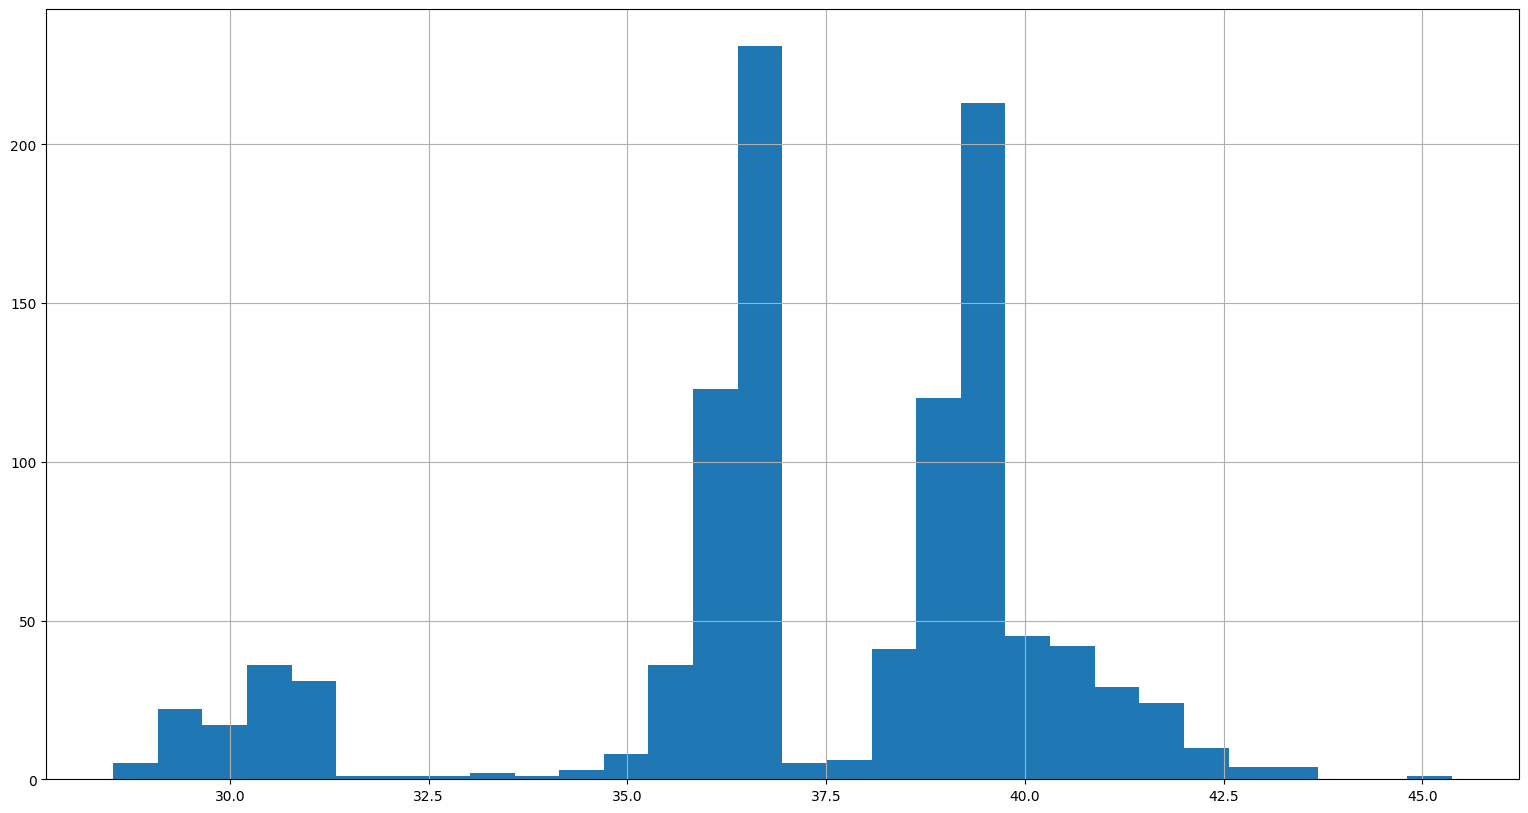

In [19]:
sales[(sales['item_id'] == '81e546c3ac97')]['price_base'].hist(grid=True, figsize=(19, 10), bins=30);

* id b0d24502fb66 - \это пакеты, что впринципе реалистично с таким большим кол-во продаж в день, но непонятно почему где-то пакеты стоят 6-8 руб, а где-то 0.01, возможно это акция действует если покупательский чек набрал большую сумму.
* id 327c5bc1e583 - отсуствует в каталоге, будет удален при создании общей таблицы
* id 81e546c3ac97 - Проверил id, для понимания примерной используемой валюты датасета, хлеб стоит около 35-40, что подходит под рубли. Так-же видно что он продаеться по 10 руб. возможно бывают скидки, акции, уценки, когда его продают по заниженой цене

In [20]:
sales[sales['quantity'] < 0].head()

,date,item_id,quantity,price_base,sum_total,store_id
2213,2023-08-04,eabcd9da5a8e,-1.43,4.90,-7.00,1
4956,2023-08-04,8d0a2068aa75,-4.00,126.00,-504.00,1
9957,2023-08-08,2f57275be77b,-1.00,2000.00,-2000.00,1
14012,2023-08-08,95879f411e24,-1.00,115.94,-115.94,1
16440,2023-08-09,4e0ef6cff251,-0.69,-32.39,22.19,1


In [21]:
sales[sales['quantity'] < 0].value_counts('item_id').head()

item_id
d2a723103e16    91
bfbe447da8d1    23
d489223074df    12
7ffc5b5b01d9    11
2f2e751f10ec    10
dtype: int64

In [22]:
catalog[catalog['item_id'] == 'bfbe447da8d1']

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
98590,bfbe447da8d1,ФРУКТЫ,ЯГОДЫ,ЯГОДЫ,Голубика,NaN,NaN,NaN


Видны отрицательные значения в quantity, price_base, sum_total. Возможно это связано со списыванием товаров. Но так-же есть минусовые цены на товар [-0.685	-32.39	22.19], скорее всего это ошибка ввода, переделаем в положительные значения	

#### price_base

In [23]:
sales[sales['price_base'] < 0]['store_id'].value_counts()

1    34
4    17
2    12
3     4
Name: store_id, dtype: int64

Предположение что отрицательные значения могут быть в одном магазине неоправдались

In [24]:
sales['price_base'] = sales['price_base'].abs()

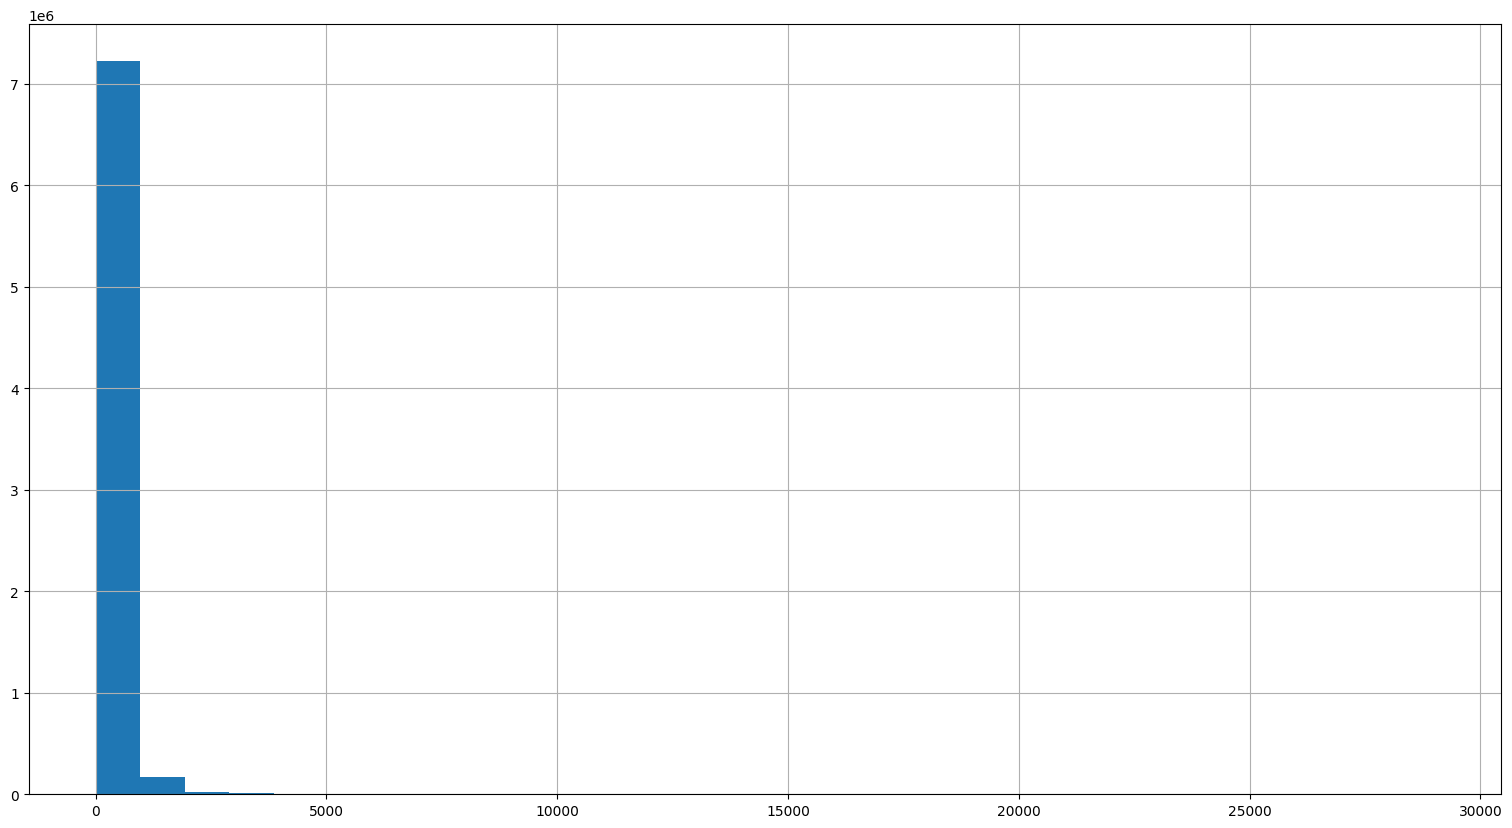

In [25]:
sales['price_base'].hist(grid=True, figsize=(19, 10), bins=30);

In [26]:
sales[sales['price_base'] > 5000]

,date,item_id,quantity,price_base,sum_total,store_id
1506,2023-08-04,f582730c3473,0.10,7999.00,799.90,1
1691,2023-08-04,de8f7c69ab12,0.37,5999.00,2219.63,1
4108,2023-08-04,08a06d2cc7e0,1.00,9999.90,9999.90,1
4791,2023-08-04,ddf708790412,1.00,5999.90,5999.90,1
13056,2023-08-08,de8f7c69ab12,0.07,5999.00,419.93,1
...,...,...,...,...,...,...
7426676,2024-09-25,f946a860f781,1.00,6999.90,6999.90,4
7426690,2024-09-25,0152cd39c554,1.00,6990.00,6990.00,4
7431410,2024-09-26,139439461cb7,0.16,9290.00,1504.98,4
7431506,2024-09-26,6fa36235831f,0.47,9290.00,4347.72,4


In [27]:
sales[sales['price_base'] > 10000].value_counts('item_id').head(10)

item_id
76dc491fa971    46
ce9649d114b1    43
b226f2472756    30
46e99a26545f    19
33dd4df7022d    17
dee614a9ea4d     8
1471e5bdd11f     7
e17a23cef25b     6
951987144df7     5
bf7ae39ed214     5
dtype: int64

In [28]:
sales[sales['price_base'] > 10000].sort_values('price_base', ascending = False).head()

,date,item_id,quantity,price_base,sum_total,store_id
5887744,2023-12-20,33dd4df7022d,1.00,28999.90,28999.90,4
6208293,2024-02-20,33dd4df7022d,1.00,28999.90,28999.90,4
5950957,2023-12-31,33dd4df7022d,1.00,28999.90,28999.90,4
1942223,2024-09-05,33dd4df7022d,1.00,26490.00,26490.00,1
1598320,2024-06-29,33dd4df7022d,1.00,26490.00,26490.00,1


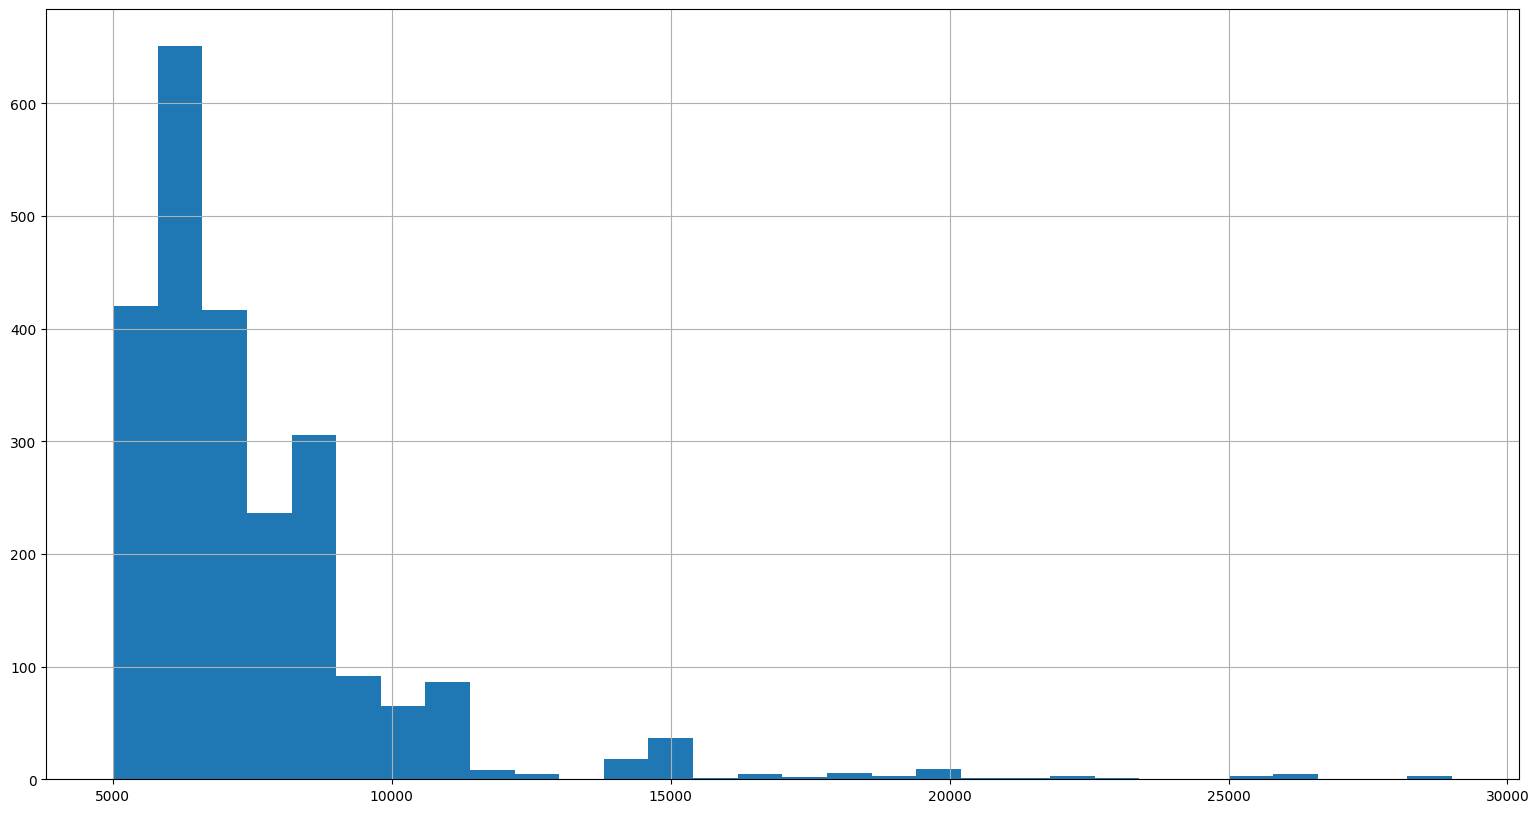

In [29]:
sales[sales['price_base'] > 5000]['price_base'].hist(grid=True, figsize=(19, 10), bins=30);

In [30]:
catalog[catalog['item_id'] == '33dd4df7022d']

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
25729,33dd4df7022d,КОНЬЯК,ИМПОРТ,КОНЬЯК,Коньяк,0.70,0.70,NaN


In [31]:
catalog[catalog['item_id'] == 'be8613b521dc']

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
14845,be8613b521dc,ИКРА РЫБ ОСЕТРОВЫХ ПОРОД,ИКРА ОСЕТРОВЫХ ПОРОД,Ж/Б,Черная,0.25,0.25,NaN


Высокие значения цены не аномальны, так как есть реальные товары, которые могут так много стоить. 

#### sum_total

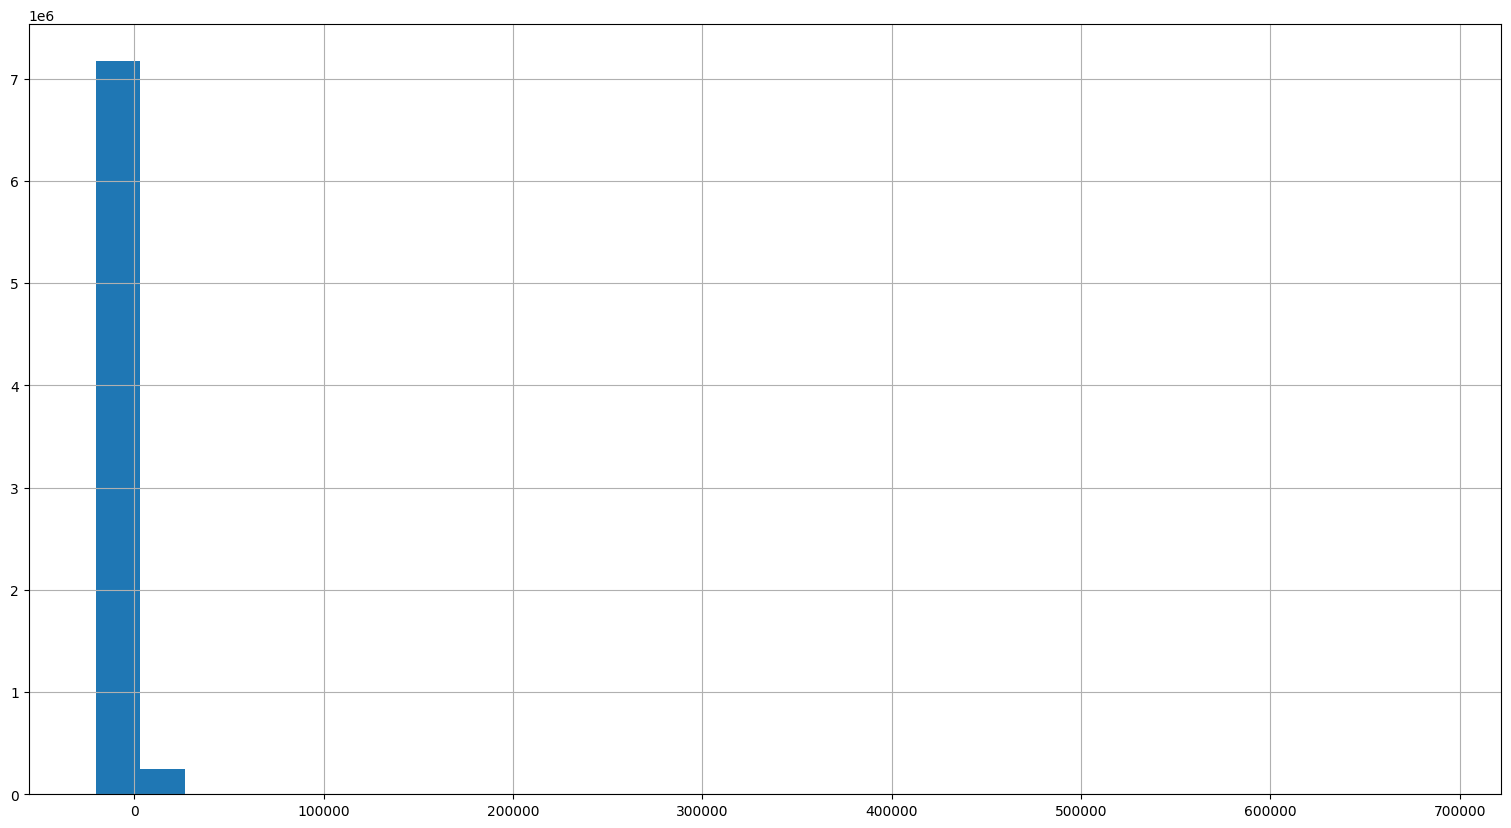

In [32]:
sales['sum_total'].hist(grid=True, figsize=(19, 10), bins=30);

In [33]:
sales[sales['sum_total'] > 10000].sort_values('sum_total', ascending = False).head(10)

,date,item_id,quantity,price_base,sum_total,store_id
5949414,2023-12-31,9a7e315f3f42,1158.15,592.78,686524.21,4
6297922,2024-03-08,9a7e315f3f42,1148.29,592.30,680127.66,4
6291799,2024-03-07,9a7e315f3f42,1075.59,592.05,636806.55,4
5853926,2023-12-14,9a7e315f3f42,1056.30,591.38,624675.95,4
6641871,2024-05-09,9a7e315f3f42,982.33,590.03,579608.32,4
7394216,2024-09-20,9a7e315f3f42,866.85,652.54,565659.25,4
6726171,2024-05-24,9a7e315f3f42,943.20,590.91,557346.98,4
6534282,2024-04-20,9a7e315f3f42,962.86,576.64,555224.77,4
7158487,2024-08-09,9a7e315f3f42,851.81,646.90,551036.93,4
728791,2024-01-09,63161948a95a,1219.00,450.00,548550.00,1


In [34]:
catalog[catalog['item_id'] == '9a7e315f3f42']

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
86591,9a7e315f3f42,ДОМАШНЯЯ КУХНЯ,ДОМАШНЯЯ КУХНЯ,СОБЕРИ САМ,NaN,NaN,NaN,NaN


In [35]:
catalog[catalog['item_id'] == '63161948a95a']

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
3271,63161948a95a,ВСПОМОГАТЕЛЬНАЯ ГРУППА,УСЛУГА И АРЕНДА,ПОДАРОЧНАЯ КАРТА,NaN,NaN,NaN,NaN


Не будем удалять высокие значения, так-как незнаю что предпологаеться под товаром Собери Сам. 

Проверим данные на соотвествие с формулой quantity * price_base = sum_total

In [36]:
def check_inaccuracies(df):
    """
    Проверяет строки, где расхождение между sum_total и calculated_sum_total составляет 5% или более.    
    :param df: Исходный DataFrame
    :return: DataFrame с ошибками
    """
    # Рассчитываем ожидаемое значение sum_total
    df['calculated_sum_total'] = df['quantity'] * df['price_base']    
    # Вычисляем абсолютное расхождение в процентах
    df['percentage_diff'] = abs((df['sum_total'] - df['calculated_sum_total']) / df['calculated_sum_total'] * 100)
    # Находим строки с расхождением 5% или более
    inaccurate_rows = df[df['percentage_diff'] >= 5]
    return inaccurate_rows[['date', 'item_id', 'quantity', 'price_base', 'sum_total', 'calculated_sum_total', 'percentage_diff']]
    

def remove_inaccurate_rows(df):
    """
    Удаляет строки, где расхождение между sum_total и calculated_sum_total составляет 5% или более.    
    :param df: Исходный DataFrame
    :return: Очищенный DataFrame
    """
    # Рассчитываем ожидаемое значение sum_total
    df['calculated_sum_total'] = df['quantity'] * df['price_base']    
    # Вычисляем абсолютное расхождение в процентах
    df['percentage_diff'] = abs((df['sum_total'] - df['calculated_sum_total']) / df['calculated_sum_total'] * 100)    
    # Удаляем строки с расхождением 5% или более
    cleaned_df = df[df['percentage_diff'] < 5].drop(columns=['calculated_sum_total', 'percentage_diff'])    
    return cleaned_df

In [37]:
inaccurate_rows = check_inaccuracies(sales)
if not inaccurate_rows.empty:
    print("Найдены строки с расхождениями 5% или более:")
    print(inaccurate_rows)
else:
    print("Все данные корректны.")

Найдены строки с расхождениями 5% или более:
              date       item_id  quantity  price_base  sum_total  \
4420    2023-08-04  fbc24e98a14e      0.00        0.00      19.80   
5644    2023-08-07  76ad74eb6daa      0.00        0.00      74.00   
7454    2023-08-07  b5aac3497e3f    267.00        0.01       2.52   
9511    2023-08-07  5ada19122e86      0.00        0.00       0.90   
12365   2023-08-08  ecabaae65646      0.00        0.00       0.90   
...            ...           ...       ...         ...        ...   
7426325 2024-09-25  327c5bc1e583   3761.00        0.01      32.14   
7426484 2024-09-25  3b6cca6fbf39      0.00        0.00       0.90   
7428010 2024-09-26  a1df7666038c      0.00        0.00      -8.90   
7431611 2024-09-26  327c5bc1e583   2797.00        0.01      24.44   
7431916 2024-09-26  b5aac3497e3f    164.00        0.01       1.51   

         calculated_sum_total  percentage_diff  
4420                     0.00              inf  
5644                     0.0

In [38]:
sales = remove_inaccurate_rows(sales)

#### store_id

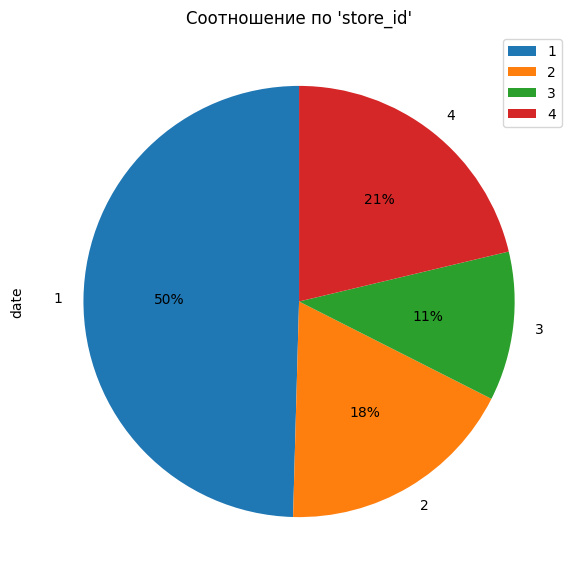

store_id
1   49.56
4   21.28
2   17.99
3   11.18


In [39]:
pivot = sales.pivot_table(index='store_id', aggfunc='count')
pivot_reset = pivot.reset_index()
pivot_reset.plot.pie(
    y=pivot_reset.columns[1],  
    labels=pivot_reset['store_id'],
    figsize=(10, 7),
    autopct="%.0f%%",
    startangle=90,
    title="Соотношение по 'store_id'"
)
plt.show()
distribution = (sales.groupby('store_id').size() / len(sales) * 100).sort_values(ascending=False).round(2)
print(distribution.to_string(index=True))

In [40]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7423002 entries, 0 to 7432684
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   item_id     object        
 2   quantity    float64       
 3   price_base  float64       
 4   sum_total   float64       
 5   store_id    int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 396.4+ MB


### Online

Описательная статистика:
        quantity  price_base  sum_total   store_id
count 1123412.00  1123412.00 1123412.00 1123412.00
mean        2.19      149.80     225.91       1.66
std         3.88      219.37     420.54       1.24
min         0.00    -8458.33    -341.88       1.00
25%         1.00       43.34      61.48       1.00
50%         1.00       78.69     110.96       1.00
75%         2.00      169.26     222.90       1.00
max       999.00    12171.62   43556.44       4.00

Гистограммы распределения:


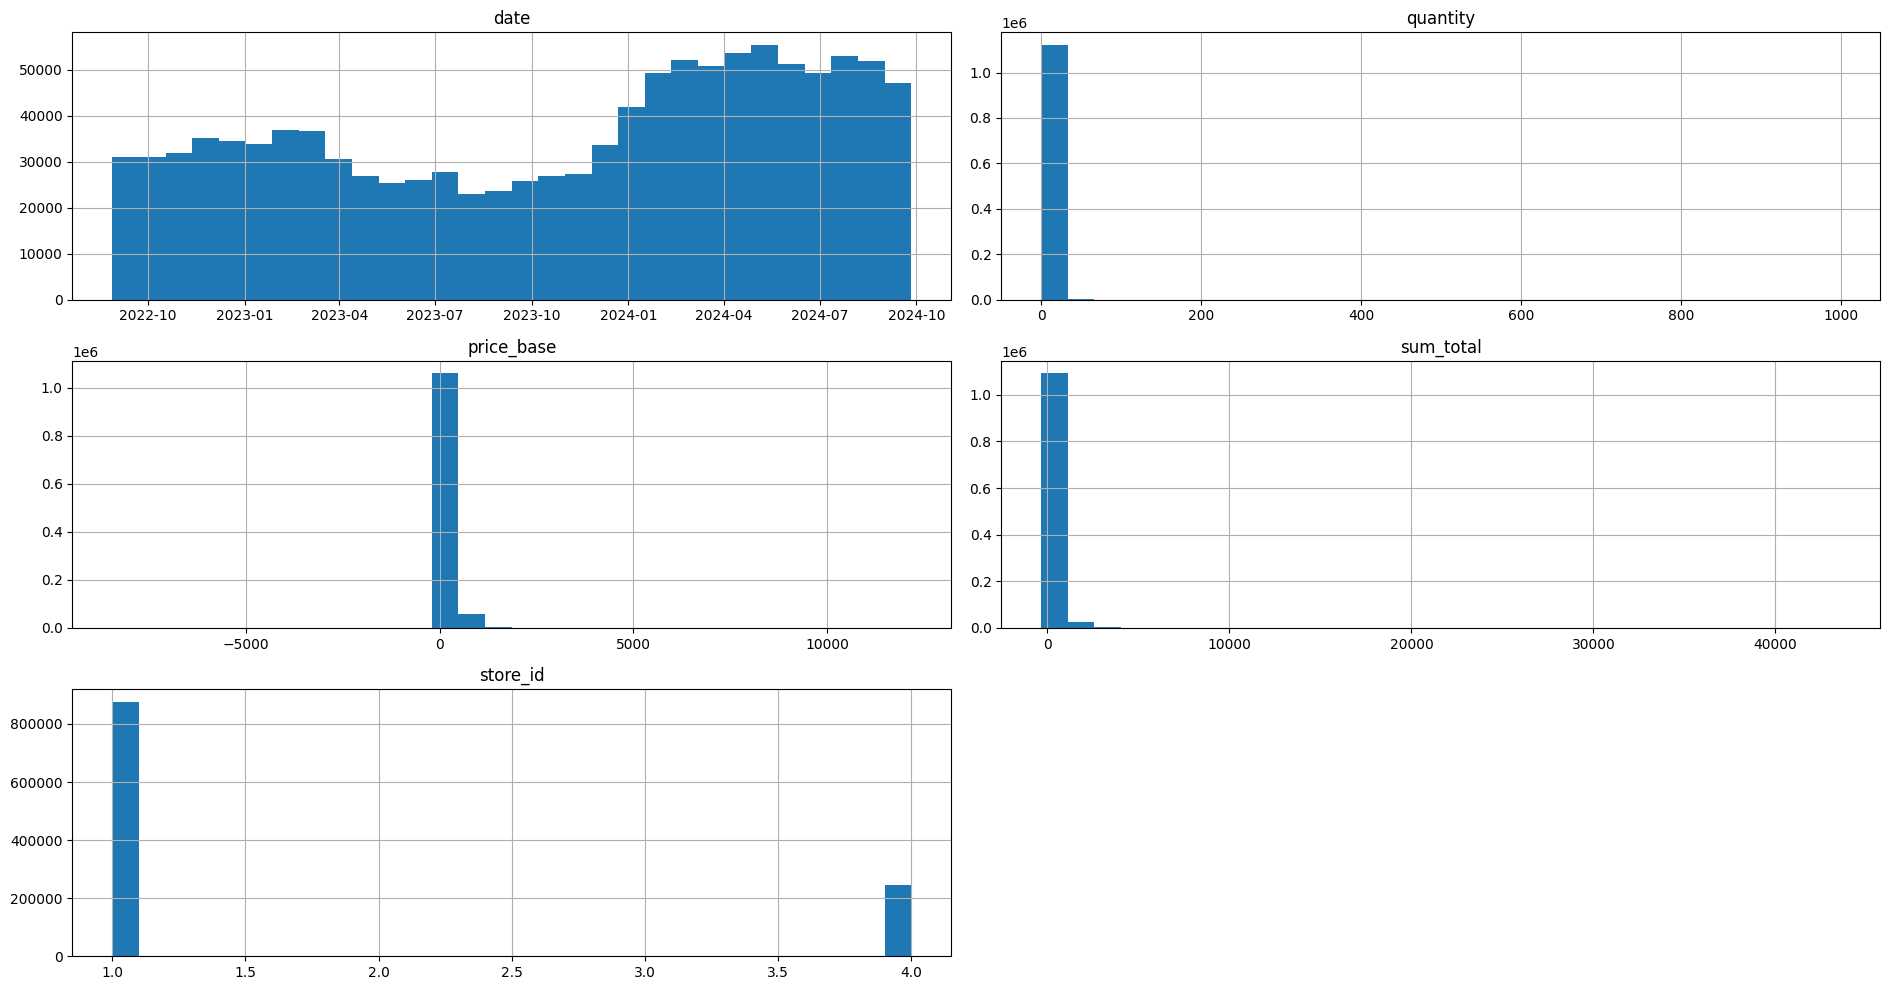

In [41]:
analyze_sales(online)

#### quantity

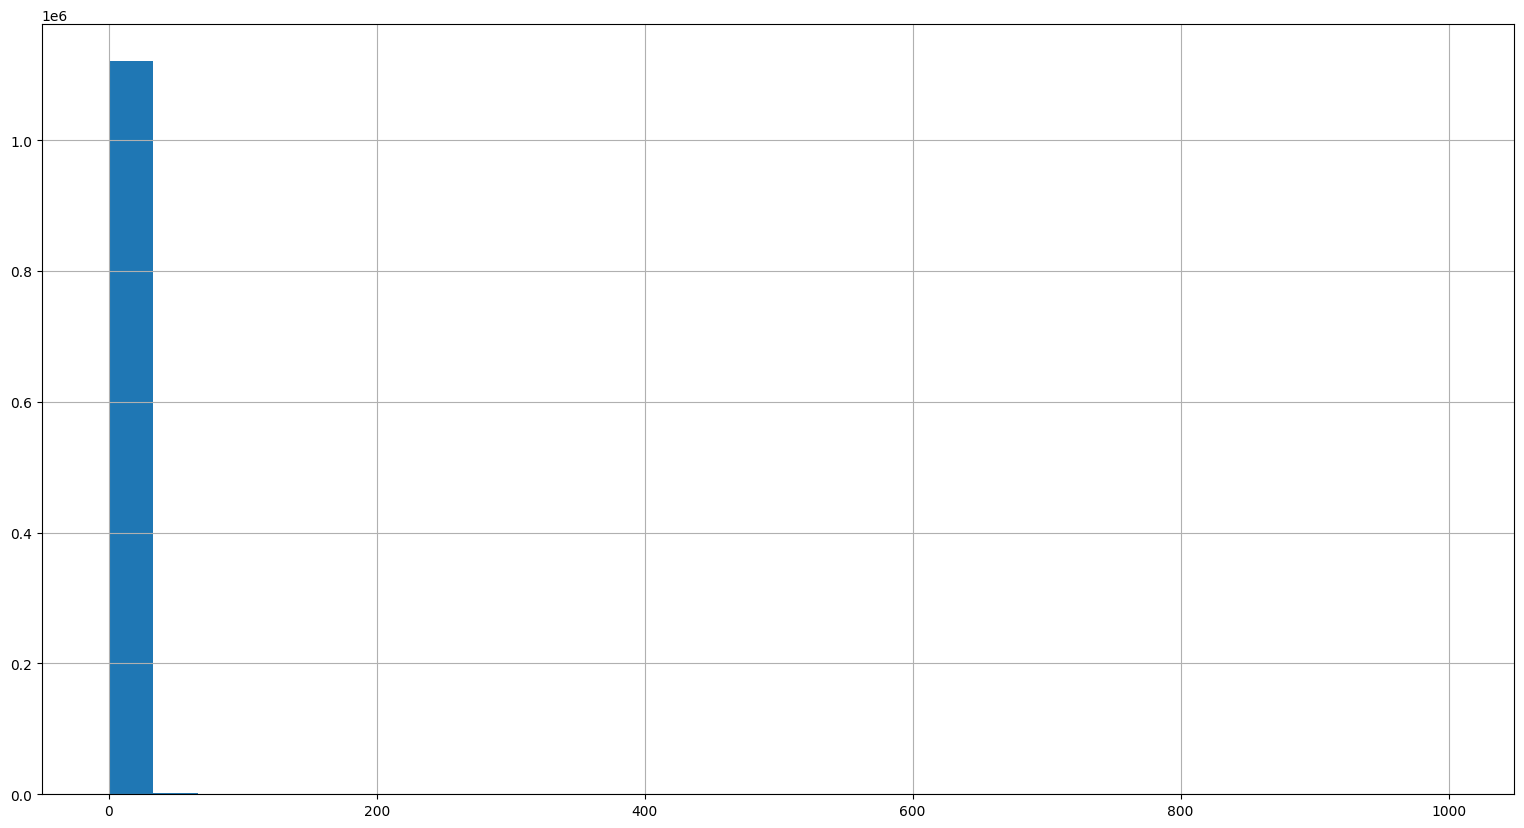

In [42]:
online['quantity'].hist(grid=True, figsize=(19, 10), bins=30);

In [43]:
online[online['quantity'] > 200]

,date,item_id,quantity,price_base,sum_total,store_id
12591,2023-08-25,49eced5b5421,356.00,62.97,22418.89,1
543182,2022-11-09,fd2978388bac,999.00,38.38,38338.86,1
614207,2022-12-30,1f14dfe5d045,226.98,25.76,5846.96,1
669488,2023-02-10,6d284b4e9982,222.00,58.10,12897.15,1
671371,2023-02-11,6d284b4e9982,221.00,58.09,12838.19,1
673261,2023-02-12,6d284b4e9982,239.00,58.09,13883.87,1
1091002,2024-08-19,355da60ff933,300.00,145.19,43556.44,4


In [44]:
catalog[catalog['item_id'] == 'fd2978388bac']

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
4589,fd2978388bac,"СПЕЦИИ,ПРИПРАВА",МОНОСПЕЦИИ,МОНОСПЕЦИИ,"Специи,Приправа",0.02,0.02,NaN


Значение 999 явно выделяеться, удалим его

In [45]:
online = online[online['quantity'] < 400]

#### price_base

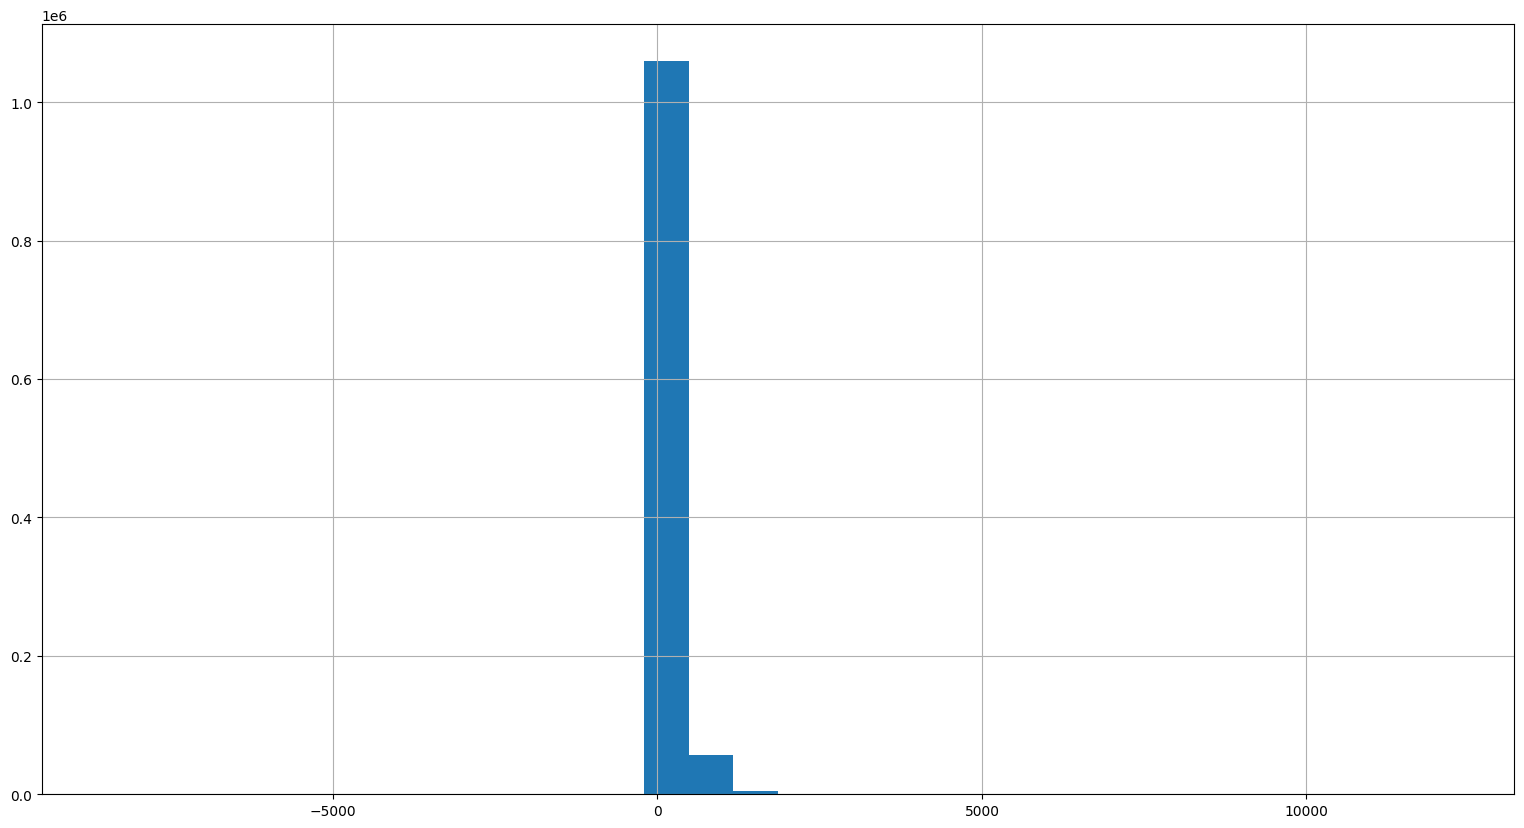

In [46]:
online['price_base'].hist(grid=True, figsize=(19, 10), bins=30);

Высокие значения так-же из-за высоких цен на товары

In [47]:
online[online['price_base'] < 0]

,date,item_id,quantity,price_base,sum_total,store_id
48088,2023-09-30,f97e09465bd9,0.00,-110.00,-0.44,1
80034,2023-10-30,95f7fc6882d6,0.04,-54.50,-2.18,1
444802,2024-09-19,b178700122d3,0.05,-452.26,-23.97,1
470806,2022-09-12,44c942fe217c,3.00,-113.96,-341.88,1
561890,2022-11-23,0f6c32f3819f,0.14,-12.64,-1.77,1
683240,2023-02-19,e6a089921dee,0.01,-8458.33,-50.75,1


In [48]:
online = online[online['price_base'] > 0]

In [49]:
inaccurate_rows = check_inaccuracies(online)
if not inaccurate_rows.empty:
    print("Найдены строки с расхождениями 5% или более:")
    print(inaccurate_rows)
else:
    print("Все данные корректны.")

Найдены строки с расхождениями 5% или более:
              date       item_id  quantity  price_base  sum_total  \
444411  2024-09-19  327c5bc1e583     42.00        0.01       0.49   
1120528 2024-09-23  327c5bc1e583     51.00        0.01       0.55   

         calculated_sum_total  percentage_diff  
444411                   0.42            16.67  
1120528                  0.51             7.84  


In [50]:
online = remove_inaccurate_rows(online)

#### sum_total

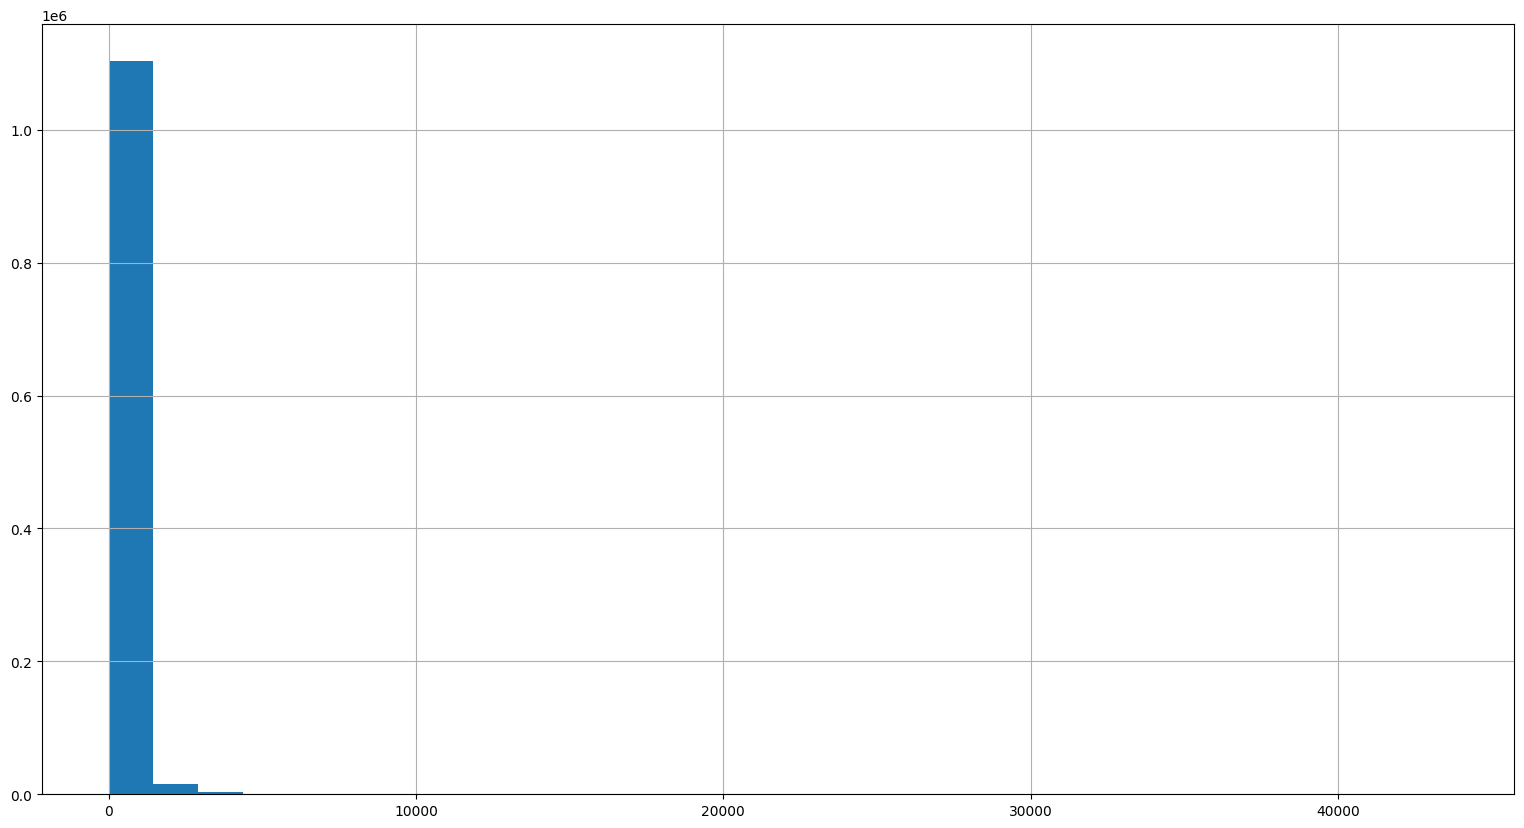

In [51]:
online['sum_total'].hist(grid=True, figsize=(19, 10), bins=30);

In [52]:
online[online['sum_total'] > 10000].sort_values('sum_total', ascending = False).head(10)

,date,item_id,quantity,price_base,sum_total,store_id
1091002,2024-08-19,355da60ff933,300.00,145.19,43556.44,4
125421,2023-12-10,bf7ae39ed214,3.00,12171.62,36514.86,1
921579,2024-02-17,f7e39319f95d,72.00,460.00,33119.92,4
645361,2023-01-23,40f2cdc35fbe,71.53,357.57,25577.25,1
1071693,2024-07-31,355da60ff933,156.00,146.00,22776.68,4
1079219,2024-08-08,355da60ff933,156.00,145.27,22661.88,4
12591,2023-08-25,49eced5b5421,356.00,62.97,22418.89,1
1066739,2024-07-26,355da60ff933,110.00,170.73,18780.58,4
1058674,2024-07-17,355da60ff933,108.00,170.17,18378.53,4
915743,2024-02-11,383049250868,7.00,2429.35,17005.46,4


#### store_id

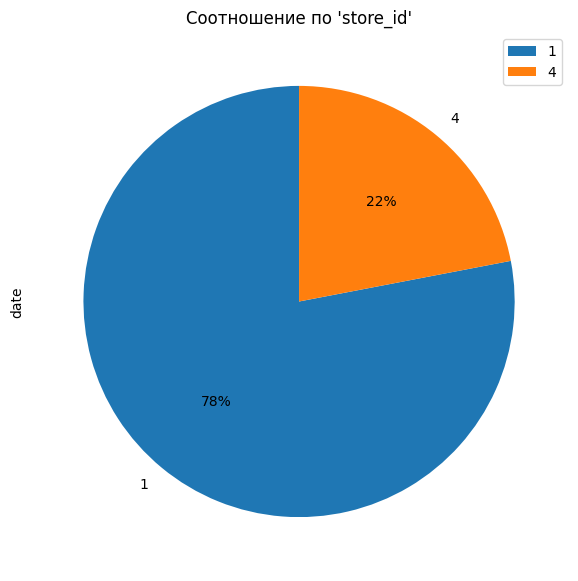

store_id
1   78.02
4   21.98


In [53]:
pivot = online.pivot_table(index='store_id', aggfunc='count')
pivot_reset = pivot.reset_index()
pivot_reset.plot.pie(
    y=pivot_reset.columns[1],  
    labels=pivot_reset['store_id'],
    figsize=(10, 7),
    autopct="%.0f%%",
    startangle=90,
    title="Соотношение по 'store_id'"
)
plt.show()
distribution = (online.groupby('store_id').size() / len(online) * 100).sort_values(ascending=False).round(2)
print(distribution.to_string(index=True))

Магазины поддерживающей онлайн только 1 и 4

### Catalog

Описательная статистика:
       weight_volume  weight_netto  fatness
count       82952.00      48957.00  7212.00
mean            2.91          0.77    15.44
std            33.89         35.44    23.18
min             0.00         -0.65     0.03
25%             0.20          0.10     2.50
50%             0.45          0.23     3.60
75%             0.75          0.50    20.00
max          3500.00       7200.00   458.00

Гистограммы распределения:


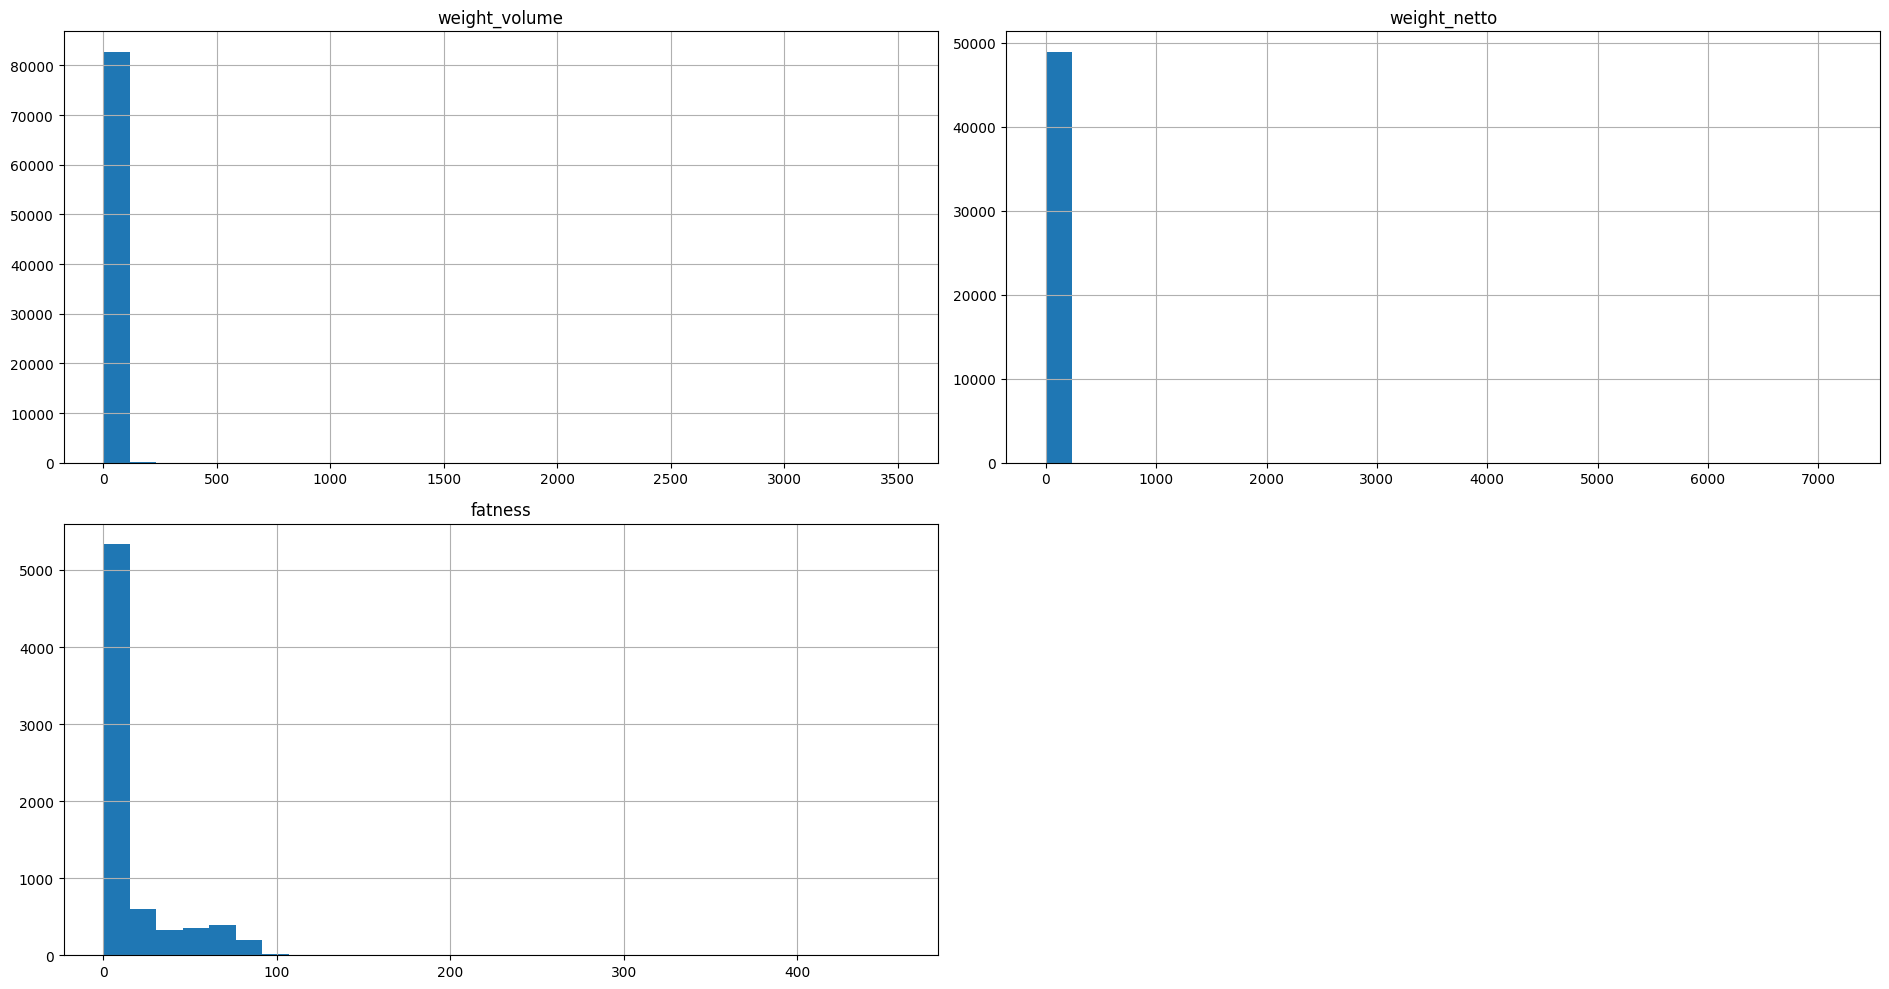

In [54]:
analyze_sales(catalog)

In [55]:
catalog.head()

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
0,da17e2d5feda,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,БУМАЖНАЯ ПРОДУКЦИЯ,ВЛАЖНЫЕ САЛФЕТКИ,NaN,150.00,NaN,NaN
1,614de2b96018,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,30.00,NaN,NaN
2,0c1f1f3e3e11,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,NaN,NaN,NaN
3,71a7fa99f005,ТОВАРЫ ДЛЯ ДОМА,ПОСУДА,КУХОННАЯ ПОСУДА,NaN,NaN,NaN,NaN
4,ec1bd4d59fe9,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,30.00,NaN,NaN


#### item_id

In [56]:
catalog['item_id'].duplicated().sum()

0

#### dept_name

In [57]:
catalog['dept_name'].value_counts().head(10)

ТОВАРЫ ДЛЯ ДОМА                   13600
ПЕРСОНАЛЬНЫЙ УХОД                 10529
ВИНО                               9792
ДЕТСКИЙ МИР                        9097
СЛАДКИЕ МУЧНЫЕ ИЗДЕЛИЯ             6688
ТОВАРЫ ДЛЯ ПРАЗДНИКА               5048
КОНФЕТЫ                            4657
ТОВАРЫ ДЛЯ ЛИЧНОГО ПОЛЬЗОВАНИЯ     4576
ХЛЕБ                               4549
КАФЕ ВОЛКОНСКИЙ                    4514
Name: dept_name, dtype: int64

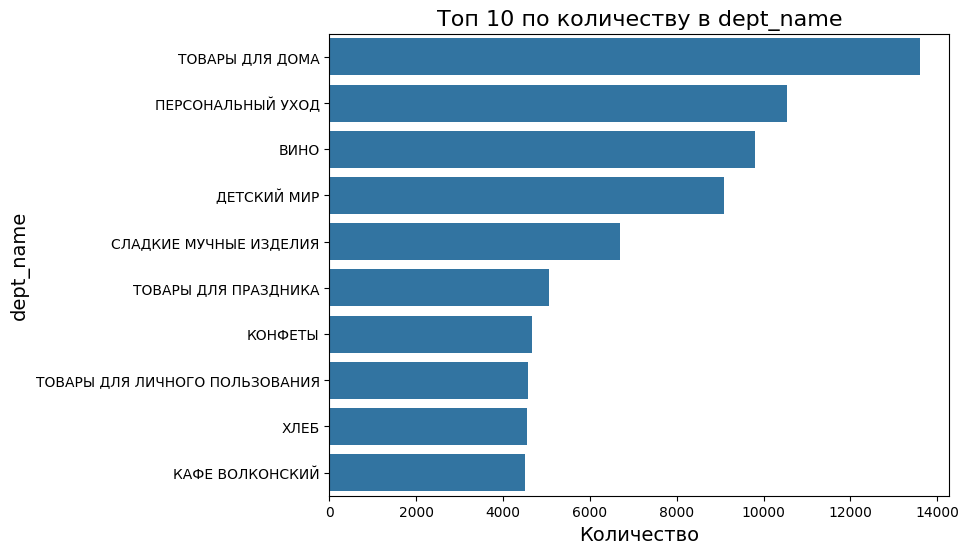

In [58]:
def categoral_unique(df, col, top_n=10):
    top_categories = df[col].value_counts().nlargest(top_n).index
    top_df = df[df[col].isin(top_categories)]
    plt.figure(figsize=(8, 6))
    plot = sns.countplot(y=col, data=top_df, order=top_categories)
    plot.set_title(f'Топ {top_n} по количеству в {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)
    plot.set_ylabel(col, fontsize=14)
    plt.show()

# Пример использования
categoral_unique(catalog, 'dept_name', top_n=10)

#### class_name

In [59]:
catalog['class_name'].value_counts().head(10)

ВИНА ТИХИЕ              8691
ПОСУДА                  7882
ИГРУШКИ                 6780
ПЕЧЕНЬЕ                 5280
КАФЕ                    4633
ИНГРЕДИЕНТЫ             4271
ХОЗЯЙСТВЕННЫЕ ТОВАРЫ    3220
СДОБА                   2915
УХОД ЗА ВОЛОСАМИ        2864
НОВОГОДНИЕ ТОВАРЫ       2844
Name: class_name, dtype: int64

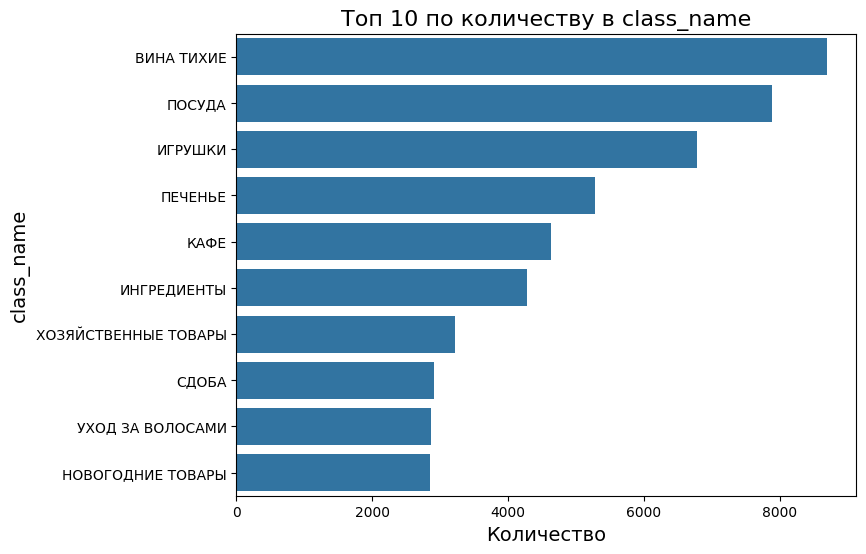

In [60]:
categoral_unique(catalog, 'class_name', top_n=10)

#### subclass_name

In [61]:
catalog['subclass_name'].value_counts().head(10)

ОТ ПРОИЗВОДИТЕЛЯ            11944
ВЕСОВЫЕ                      6135
СОБСТВЕННОЕ ПРОИЗВОДСТВО     4799
КРАСНОЕ                      4617
БЕЛОЕ                        3471
КУХОННАЯ ПОСУДА              3332
ШТУЧНЫЕ                      2760
АЛЬТЕРНАТИВА                 2656
ПЕЧЕНЬЕ ФАСОВАННОЕ           2627
УКРАШЕНИЯ                    2613
Name: subclass_name, dtype: int64

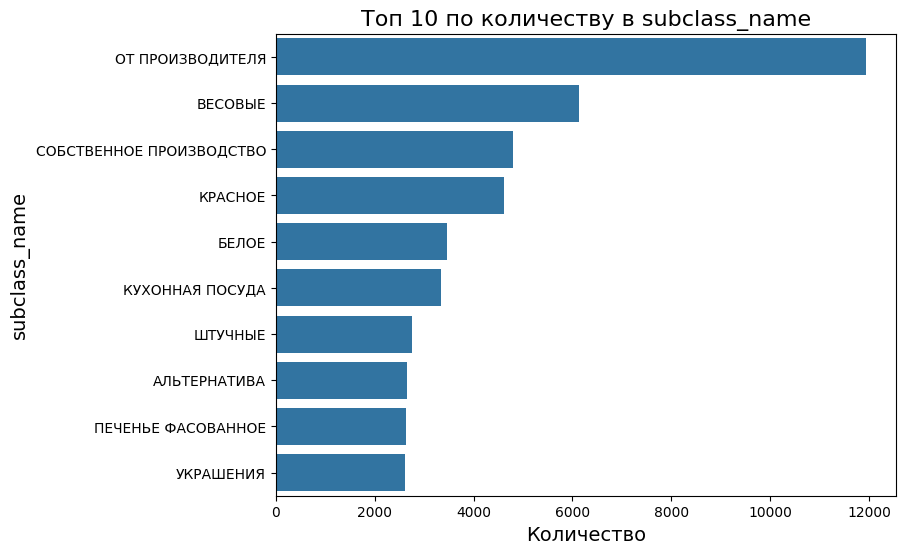

In [62]:
categoral_unique(catalog, 'subclass_name', top_n=10)

#### item_type

In [63]:
catalog['item_type'].value_counts().head(10)

Светлое        1092
Белое           878
Шоколадные      824
Печенье         806
Красное         745
Посуда          657
Чёрный          604
Шоколад         564
Развивающие     544
Кофе            513
Name: item_type, dtype: int64

In [64]:
catalog['item_type'].isnull().sum()

176224

Заполним пропуски на N/A

In [65]:
catalog['item_type'].fillna('N/A', inplace=True)

In [66]:
catalog['item_type'].value_counts().head(10)

N/A            176224
Светлое          1092
Белое             878
Шоколадные        824
Печенье           806
Красное           745
Посуда            657
Чёрный            604
Шоколад           564
Развивающие       544
Name: item_type, dtype: int64

#### weight_volume

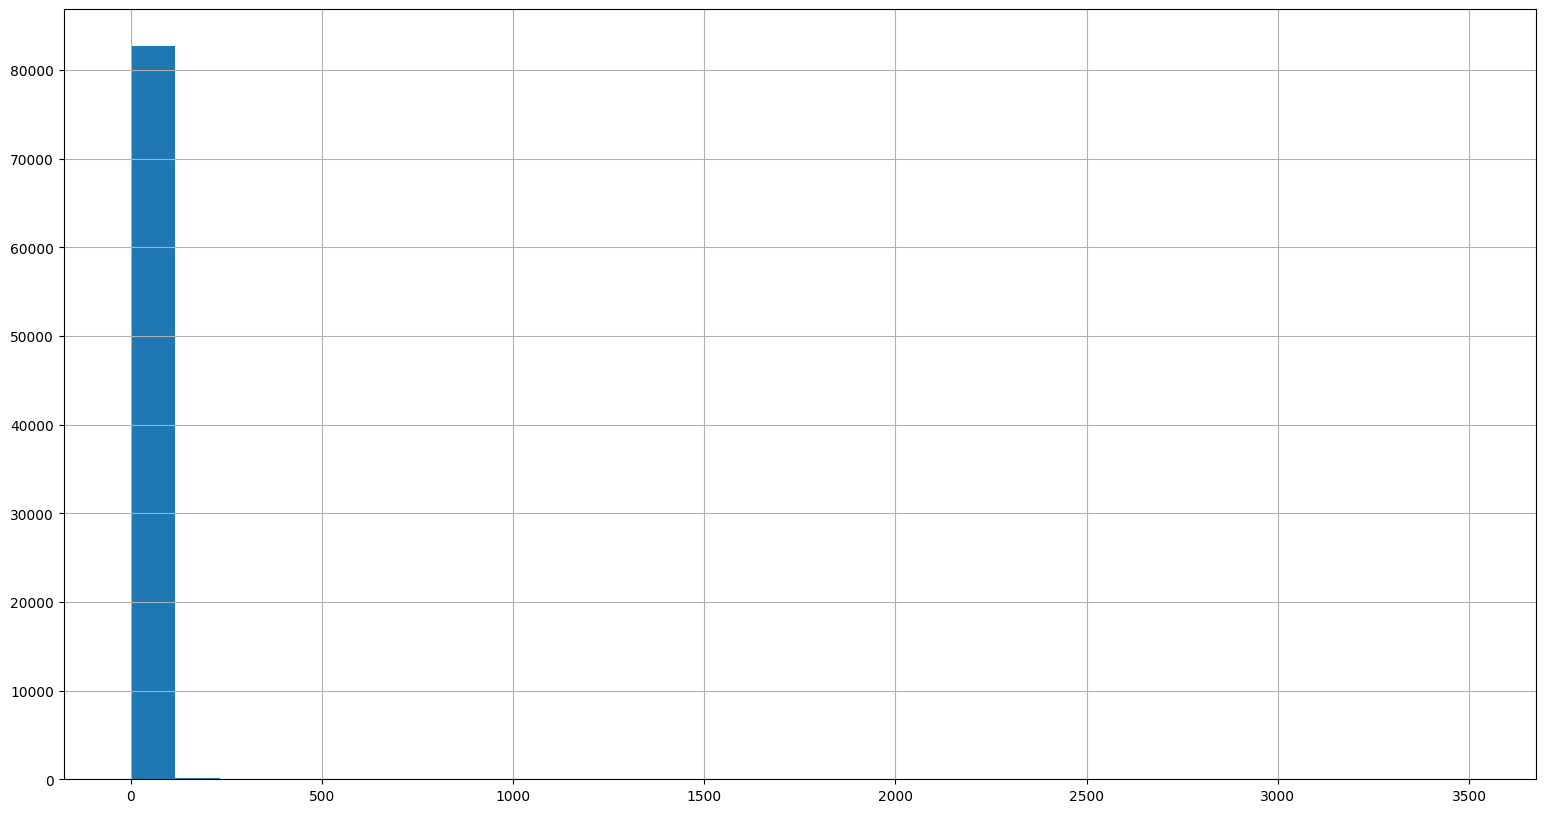

In [67]:
catalog['weight_volume'].hist(grid=True, figsize=(19, 10), bins=30);

In [68]:
catalog[catalog['weight_volume'] > 1000]

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
23404,56d63d48b2ac,ВСПОМОГАТЕЛЬНАЯ ГРУППА,МАТЕРИАЛЬНЫЙ СКЛАД,УПАКОВКА,N/A,2000.00,NaN,NaN
23409,7b92754eaee3,ВСПОМОГАТЕЛЬНАЯ ГРУППА,МАТЕРИАЛЬНЫЙ СКЛАД,УПАКОВКА,N/A,2000.00,NaN,NaN
23411,2e7a6deacb04,ВСПОМОГАТЕЛЬНАЯ ГРУППА,МАТЕРИАЛЬНЫЙ СКЛАД,УПАКОВКА,N/A,2000.00,NaN,NaN
23415,9d1412e6fc91,ВСПОМОГАТЕЛЬНАЯ ГРУППА,МАТЕРИАЛЬНЫЙ СКЛАД,УПАКОВКА,N/A,2000.00,NaN,NaN
27169,9271ad023867,ИНГРЕДИЕНТЫ,ИНГРЕДИЕНТЫ,ИНГРЕДИЕНТЫ ДЛЯ ПРОИЗВОДСТВА,N/A,3100.00,NaN,NaN
45980,7f286a68d58b,ВСПОМОГАТЕЛЬНАЯ ГРУППА,МАТЕРИАЛЬНЫЙ СКЛАД,УПАКОВКА,N/A,3000.00,NaN,NaN
71393,cfc28e8c74e1,ИНГРЕДИЕНТЫ,ИНГРЕДИЕНТЫ,ИНГРЕДИЕНТЫ ДЛЯ ПРОИЗВОДСТВА,N/A,2200.00,2.20,NaN
130943,20d6b9014ed7,ВСПОМОГАТЕЛЬНАЯ ГРУППА,МАТЕРИАЛЬНЫЙ СКЛАД,УПАКОВКА,N/A,2000.00,NaN,NaN
134170,c8449331b62d,ВСПОМОГАТЕЛЬНАЯ ГРУППА,МАТЕРИАЛЬНЫЙ СКЛАД,УПАКОВКА,N/A,1300.00,NaN,NaN
136289,7febe695f5cd,ВСПОМОГАТЕЛЬНАЯ ГРУППА,МАТЕРИАЛЬНЫЙ СКЛАД,НЕКОММЕРЧЕСКИЕ ТОВАРЫ 7 КОНТИНЕНТ,N/A,1500.00,NaN,NaN


Данные выглядят нормально, оставим так

In [69]:
catalog['weight_volume'].isnull().sum()

136858

Заполним пропуски на 0

In [70]:
catalog['weight_volume'].fillna(0, inplace=True)

In [71]:
catalog['weight_volume'].value_counts().head(10)

0.00    136858
0.50      8195
0.75      7750
1.00      5439
0.20      3612
0.25      3563
0.10      3040
0.70      2918
0.30      2493
0.40      2393
Name: weight_volume, dtype: int64

#### weight_netto

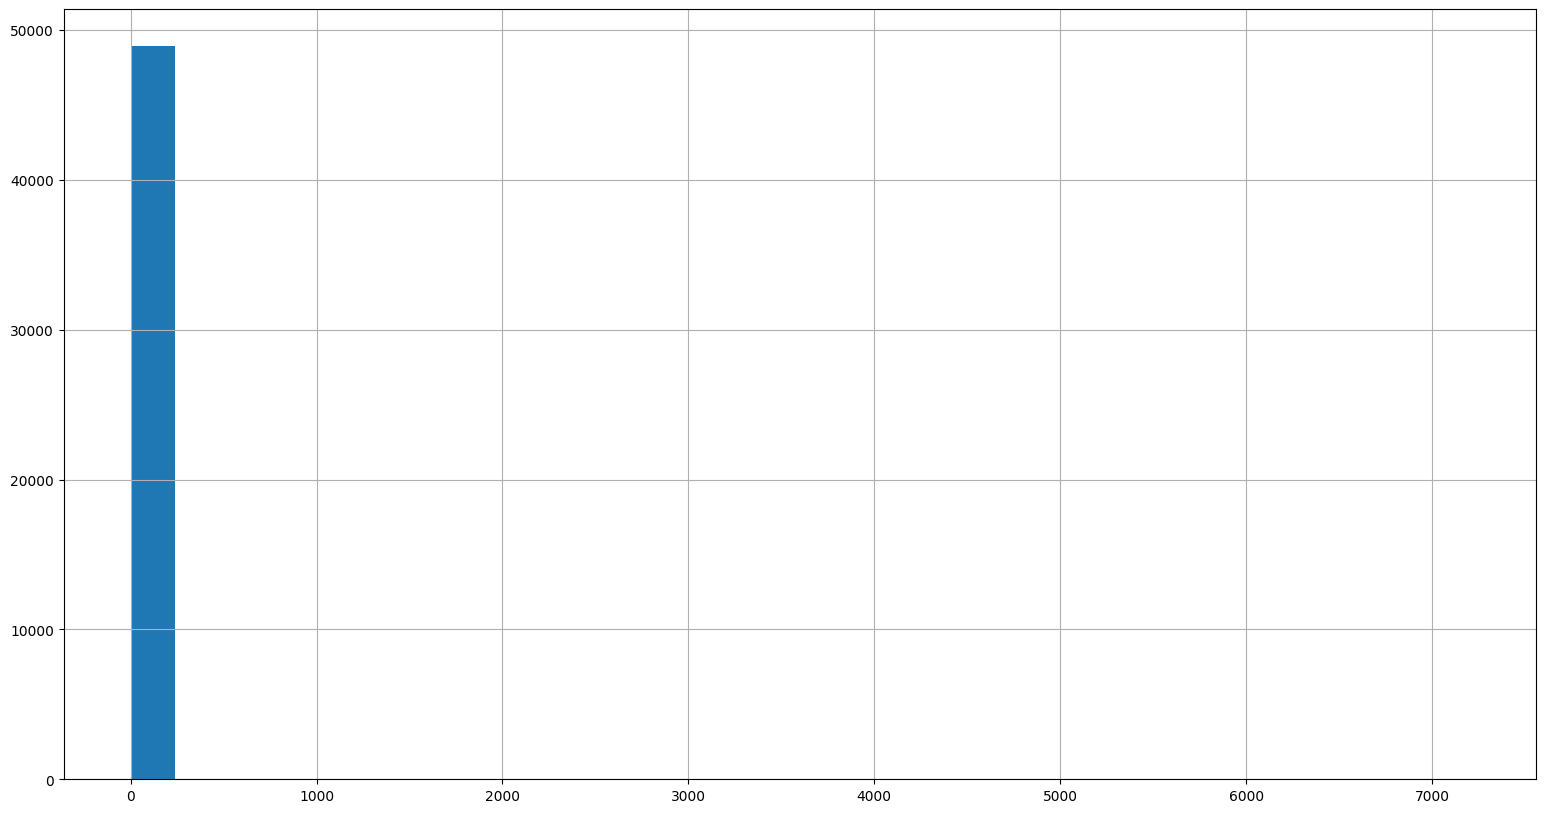

In [72]:
catalog['weight_netto'].hist(grid=True, figsize=(19, 10), bins=30);

In [73]:
catalog[catalog['weight_netto'] > 1000]

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
6356,bf8894270674,ТОРТЫ,БИСКВИТНЫЕ ШОКОЛАДНЫЕ,ОТ ПРОИЗВОДИТЕЛЯ,Торты,1.10,1100.00,NaN
6359,0b0bf97fbba3,ТОРТЫ,БИСКВИТНЫЕ БЕЛЫЕ,ОТ ПРОИЗВОДИТЕЛЯ,Торты,1.20,1200.00,NaN
31830,3c6b1db1f2f3,ТОРТЫ,БИСКВИТНЫЕ БЕЛЫЕ,ОТ ПРОИЗВОДИТЕЛЯ,Торты,1.10,1100.00,NaN
44361,d5500d3cfbfd,ТОРТЫ,БИСКВИТНЫЕ ШОКОЛАДНЫЕ,ОТ ПРОИЗВОДИТЕЛЯ,Торты,1.06,1060.00,NaN
122071,bc97f0b4d388,СЕЗОННЫЙ АССОРТИМЕНТ,НАБОРЫ НОВОГОДНИЕ,НАБОРЫ НОВОГОДНИЕ,N/A,7.20,7200.00,NaN
122669,2923ef2f4d42,ТОРТЫ,КОМБИНИРОВАННЫЕ,ОТ ПРОИЗВОДИТЕЛЯ,N/A,1.02,1020.00,NaN
153333,24fd0a244ff9,ТОРТЫ,БИСКВИТНЫЕ ШОКОЛАДНЫЕ,ОТ ПРОИЗВОДИТЕЛЯ,Торты,1.04,1040.00,NaN
153341,e5389c0d9d8d,ТОРТЫ,СУФЛЕ,ОТ ПРОИЗВОДИТЕЛЯ,Торты,1.07,1070.00,NaN


Торты оставим, а вот новогодний набор уберем, слишком большее единичное значение

In [74]:
catalog = catalog[catalog['weight_netto'] < 5000]

In [75]:
catalog['weight_netto'].isnull().sum()

0

#### fatness

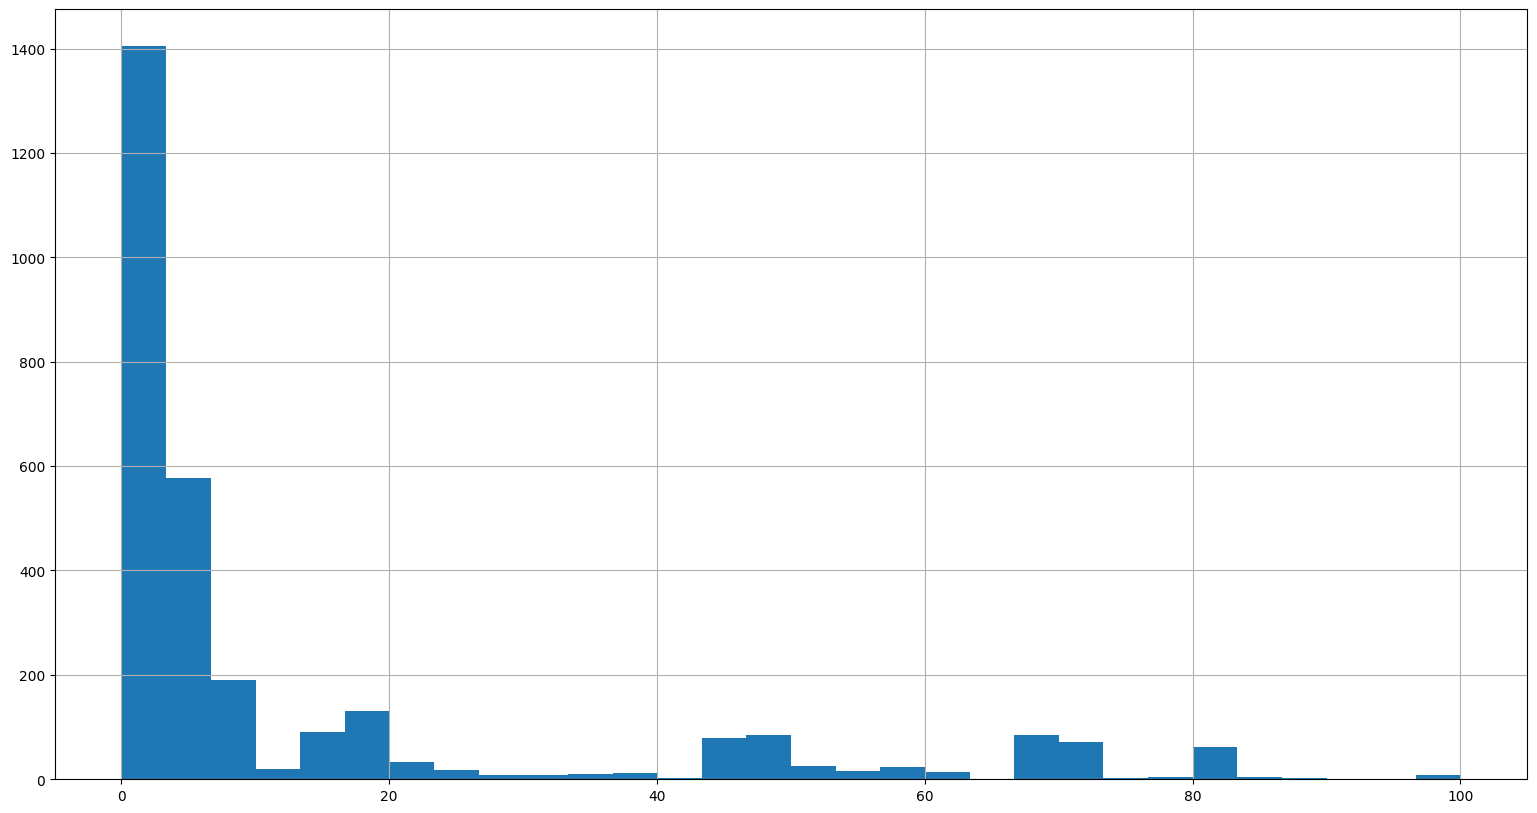

In [76]:
catalog['fatness'].hist(grid=True, figsize=(19, 10), bins=30);

In [77]:
catalog['fatness'].isnull().sum()

45966

Распределение нормальное, заполним пропуски 0

In [78]:
catalog['fatness'].fillna(0, inplace=True)

C:\Users\dinos\AppData\Local\Temp\ipykernel_11760\2250588859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog['fatness'].fillna(0, inplace=True)


In [79]:
catalog['fatness'].value_counts().head(10)

0.00     45966
2.50       332
3.20       273
5.00       146
2.00       129
20.00      123
1.50       116
4.00       114
15.00       85
45.00       80
Name: fatness, dtype: int64

### Stores

In [80]:
stores.head(10)

,store_id,division,format,city,area
0,4,Div1,MaxiEuro,City3,1887
1,3,Div2,Format-7 express,City2,109
2,2,Div2,Format-6,City1,210
3,1,Div1,Format-1,City1,1500


### Actual_matrix

In [81]:
actual_matrix.head()

,item_id,date,store_id
0,c578da8e8841,2019-10-17,1
1,4dd2b686802c,2019-10-17,1
2,16ade2e3fca9,2019-10-17,1
3,f4eb16dab09e,2019-10-17,1
4,ab1384c2af6d,2020-05-31,1


Описательная статистика:
       store_id
count  35202.00
mean       2.47
std        1.35
min        1.00
25%        1.00
50%        2.00
75%        4.00
max        4.00

Гистограммы распределения:


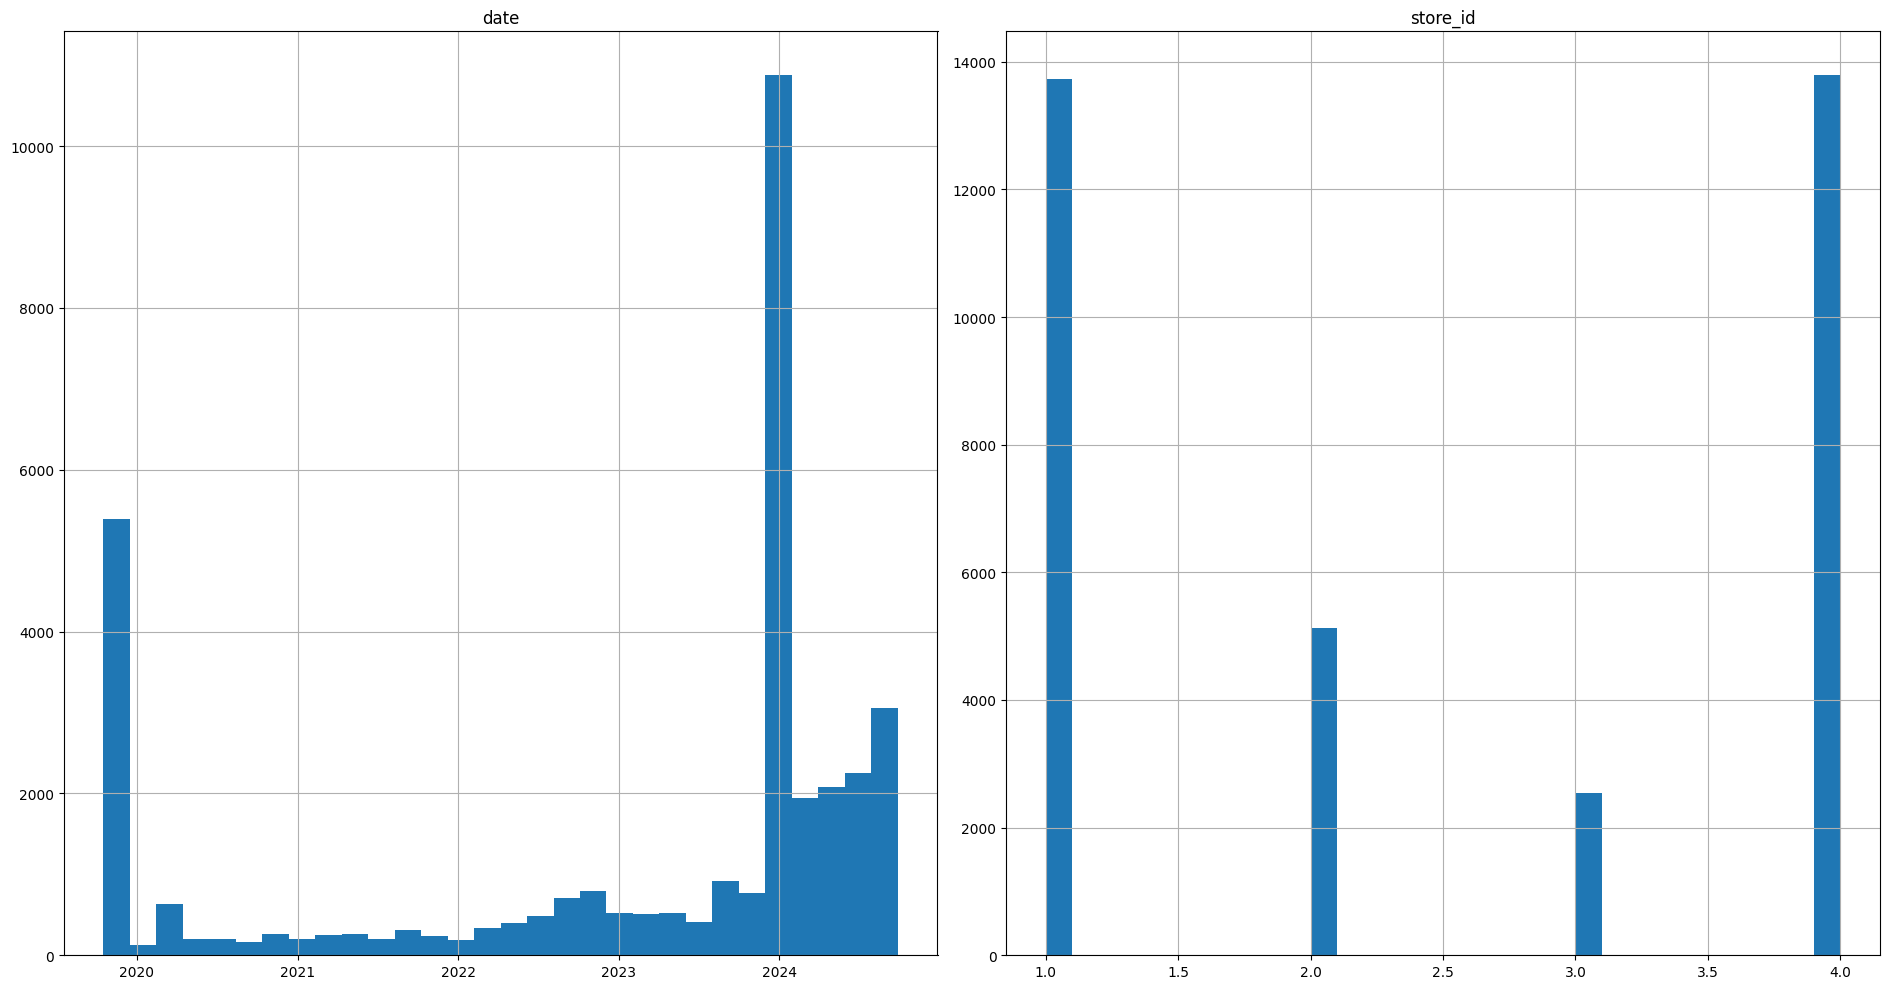

In [82]:
analyze_sales(actual_matrix)

### Markdowns

In [83]:
markdowns.head()

,date,item_id,normal_price,price,quantity,store_id
0,2023-08-01,bc2f82a22e11,189.00,100.00,8.00,1
1,2023-08-01,389412076801,179.00,100.00,5.00,1
2,2023-08-01,0e39cf5d57c1,149.00,100.00,5.00,1
3,2023-08-01,dd94e2bc5601,149.00,100.00,1.00,1
4,2023-08-01,e60d890f2812,369.00,270.00,1.00,1


Описательная статистика:
       normal_price   price  quantity  store_id
count       8979.00 8979.00   8979.00   8979.00
mean         358.35  213.30      3.07      1.91
std          220.12  141.79      4.24      1.05
min            0.00   12.50      0.12      1.00
25%          189.00  100.00      1.00      1.00
50%          239.00  150.00      2.00      2.00
75%          549.00  330.00      4.00      2.00
max         2790.00 1380.50    120.00      4.00

Гистограммы распределения:


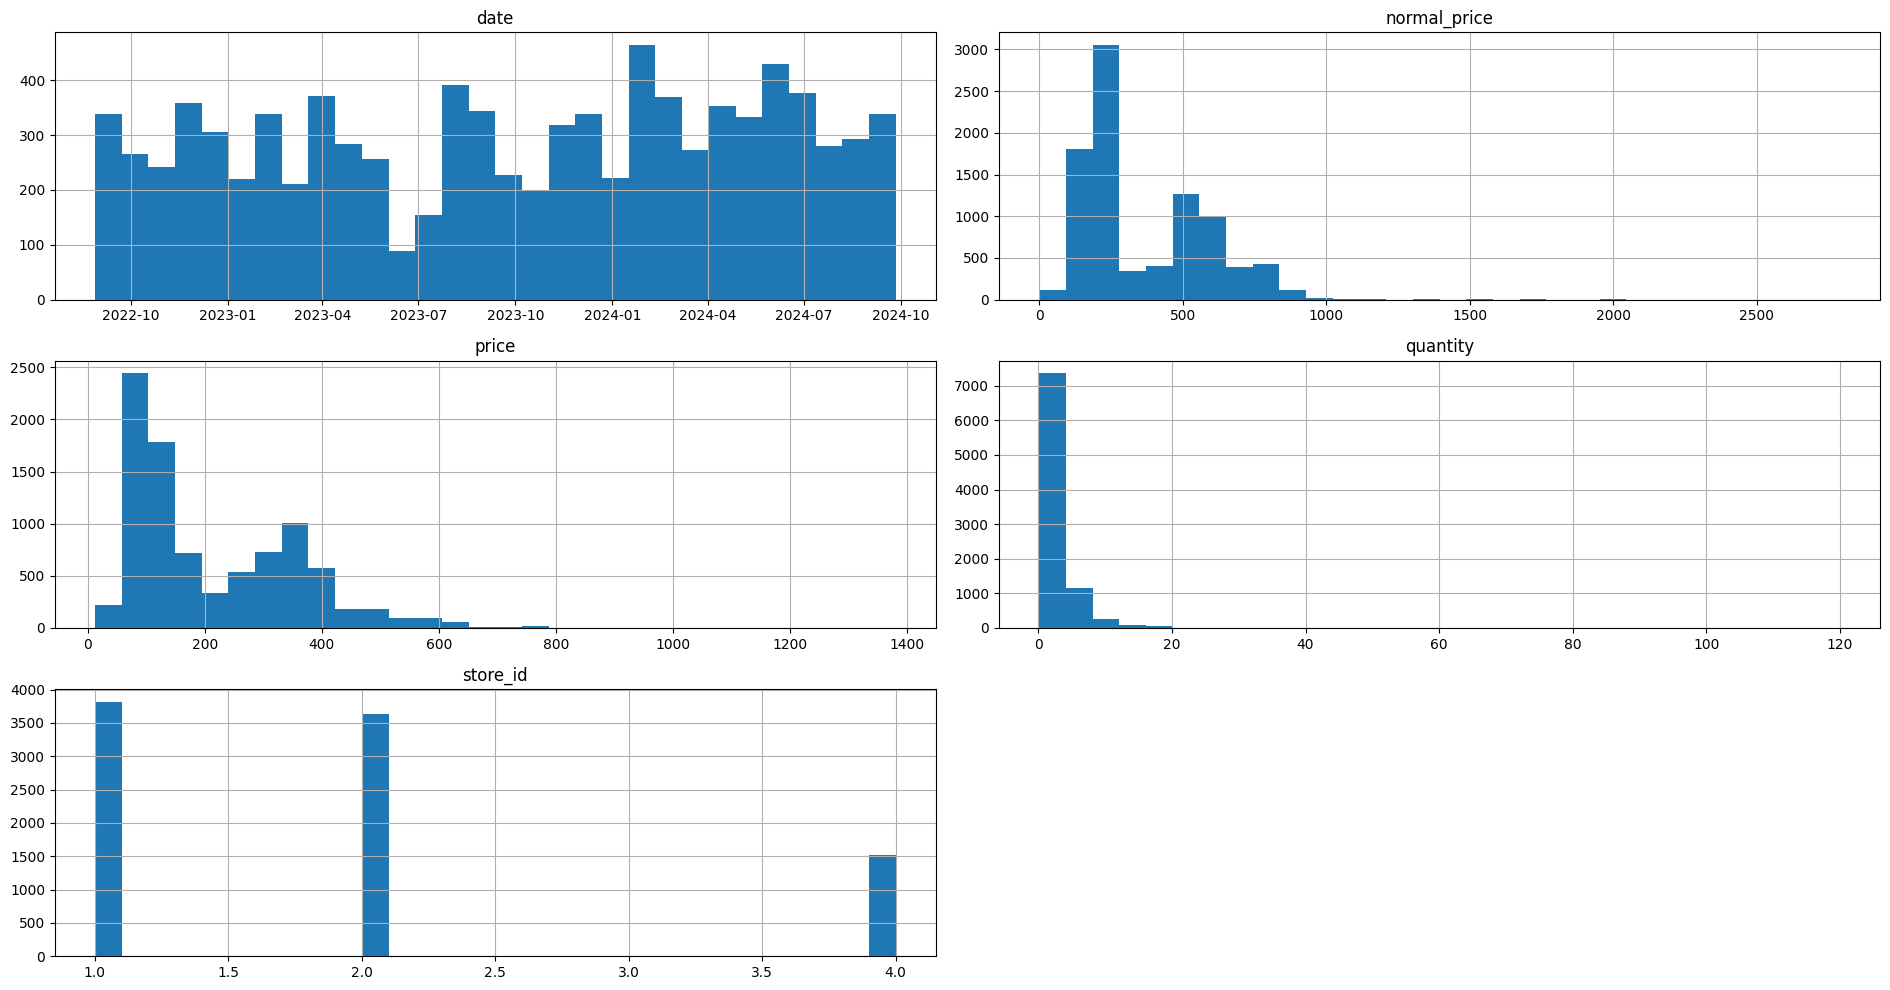

In [84]:
analyze_sales(markdowns)

In [85]:
rows_with_lower_normal_price = markdowns[markdowns['normal_price'] < markdowns['price']]
rows_with_lower_normal_price

,date,item_id,normal_price,price,quantity,store_id
168,2023-09-04,44c942fe217c,195.00,240.00,11.00,1
170,2023-09-04,a9d8c085adc0,270.00,300.00,32.00,1
172,2023-09-04,f611e25fa53a,275.00,320.00,13.00,1
177,2023-09-04,76c18abd8f7c,359.00,390.00,7.00,1
1247,2024-03-11,389412076801,119.00,120.00,9.00,1
1251,2024-03-12,389412076801,119.00,120.00,3.00,1
1254,2024-03-13,389412076801,119.00,120.00,3.00,1
1260,2024-03-14,389412076801,119.00,120.00,2.00,1
1307,2024-03-21,389412076801,119.00,120.00,1.00,1
2819,2023-01-09,291d60da77b1,332.90,339.90,2.00,1


In [86]:
markdowns = markdowns[markdowns['normal_price'] >= markdowns['price']]

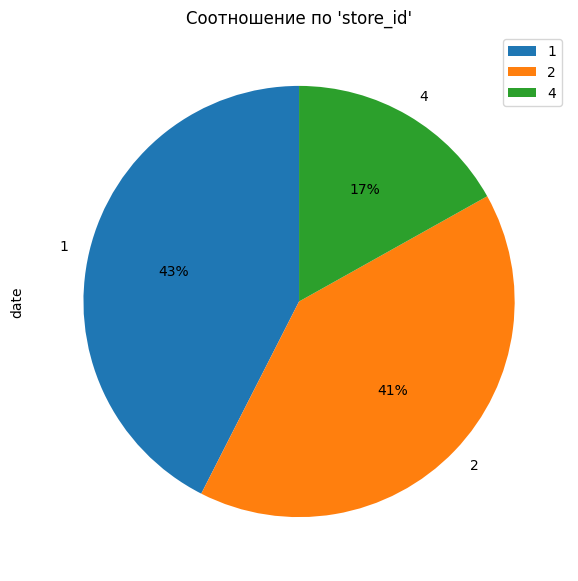

store_id
1   42.51
2   40.61
4   16.88


In [87]:
pivot = markdowns.pivot_table(index='store_id', aggfunc='count')
pivot_reset = pivot.reset_index()
pivot_reset.plot.pie(
    y=pivot_reset.columns[1],  
    labels=pivot_reset['store_id'],
    figsize=(10, 7),
    autopct="%.0f%%",
    startangle=90,
    title="Соотношение по 'store_id'"
)
plt.show()
distribution = (markdowns.groupby('store_id').size() / len(markdowns) * 100).sort_values(ascending=False).round(2)
print(distribution.to_string(index=True))

3 магазин не делает уценок на товар

### Discounts_history

Описательная статистика:
       sale_price_before_promo  sale_price_time_promo  promo_type_code  \
count               3746744.00             3746744.00       3428898.00   
mean                    425.30                 334.02             5.66   
std                     657.58                 513.40             1.86   
min                       0.00                   0.00             1.00   
25%                      84.90                  69.90             5.00   
50%                     179.90                 149.90             5.00   
75%                     499.90                 389.90             6.00   
max                   16999.90               15999.90            44.00   

       number_disc_day   store_id  
count       3746744.00 3746744.00  
mean            286.33       2.03  
std            1179.53       1.16  
min               1.00       1.00  
25%               4.00       1.00  
50%               8.00       2.00  
75%              13.00       3.00  
max            8766.

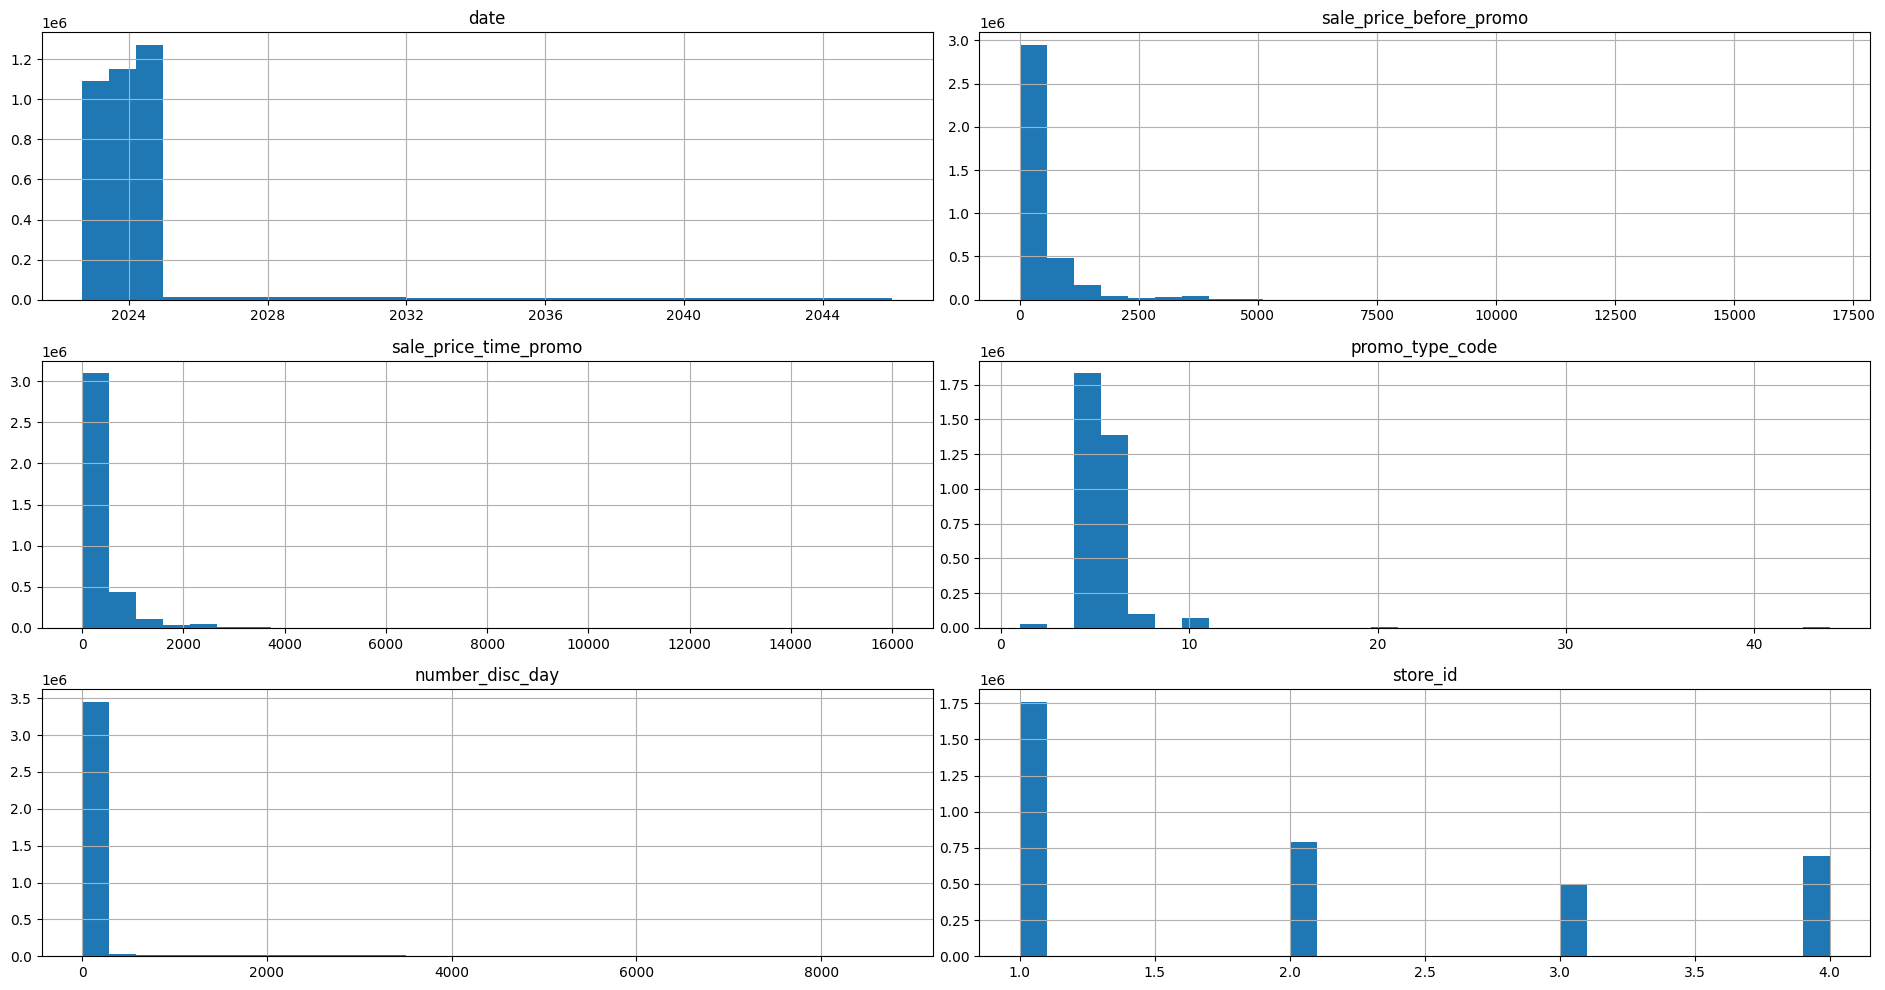

In [88]:
analyze_sales(discounts_history)

In [89]:
price = discounts_history[discounts_history['sale_price_before_promo'] < discounts_history['sale_price_time_promo']]
price

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
711789,2023-06-15,eac23fad1c99,999.90,2499.90,5.00,2313bbfc-0aab-11ee-bb93-005056afbcf1,1.00,1
714373,2023-06-16,eac23fad1c99,999.90,2499.90,5.00,2313bbfc-0aab-11ee-bb93-005056afbcf1,2.00,1
716958,2023-06-17,eac23fad1c99,999.90,2499.90,5.00,2313bbfc-0aab-11ee-bb93-005056afbcf1,3.00,1
719543,2023-06-18,eac23fad1c99,999.90,2499.90,5.00,2313bbfc-0aab-11ee-bb93-005056afbcf1,4.00,1
722128,2023-06-19,eac23fad1c99,999.90,2499.90,5.00,2313bbfc-0aab-11ee-bb93-005056afbcf1,5.00,1
...,...,...,...,...,...,...,...,...
3700655,2024-12-27,a2a7de390487,0.00,229.90,5.00,9ede779d-74be-11ef-bb94-005056afbcf1,102.00,4
3700670,2024-12-28,a2a7de390487,0.00,229.90,5.00,9ede779d-74be-11ef-bb94-005056afbcf1,103.00,4
3700685,2024-12-29,a2a7de390487,0.00,229.90,5.00,9ede779d-74be-11ef-bb94-005056afbcf1,104.00,4
3700700,2024-12-30,a2a7de390487,0.00,229.90,5.00,9ede779d-74be-11ef-bb94-005056afbcf1,105.00,4


In [90]:
catalog.query('item_id == "eac23fad1c99"')

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
96145,eac23fad1c99,ВИНО,ВИНА ИГРИСТЫЕ,ШАМПАНСКОЕ ИМПОРТ,Розовое,0.75,0.75,0.00


In [91]:
discounts_history['promo_type_code'].sort_values().value_counts()

5.00     1830002
6.00     1386037
8.00      100381
10.00      74226
1.00       20493
20.00       6942
44.00       4508
2.00        4288
19.00        735
23.00        718
16.00        273
9.00         252
12.00         43
Name: promo_type_code, dtype: int64

In [92]:
discounts_history = discounts_history.drop('doc_id', axis='columns')
discounts_history.head()

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,number_disc_day,store_id
0,2022-08-28,cde97a9ec3ef,729.90,669.90,6.00,13.00,1
1,2022-08-28,2906fbc9e11c,129.90,99.90,NaN,11.00,1
2,2022-08-28,c48c3a3d8c01,129.90,99.90,NaN,11.00,1
3,2022-08-28,f85243ca61e6,129.90,99.90,NaN,11.00,1
4,2022-08-28,27ce75534065,129.90,99.90,NaN,11.00,1


In [93]:
discounts_history['promo_type_code'].fillna(0, inplace=True)

### Price_history

In [94]:
price_history.head()

,date,item_id,price,code,store_id
0,2023-08-01,4a1f95fe4d4b,499.90,1,1
1,2023-08-01,bf43a9d3ae13,0.00,9999999999,1
2,2023-08-01,0dd8744decce,129.90,1,1
3,2023-08-01,9b38c7e4dba9,136.00,1,1
4,2023-08-01,b791e8c9347c,0.00,1,1


In [95]:
price_history = price_history.drop(1)

In [96]:
price_history.head()

,date,item_id,price,code,store_id
0,2023-08-01,4a1f95fe4d4b,499.90,1,1
2,2023-08-01,0dd8744decce,129.90,1,1
3,2023-08-01,9b38c7e4dba9,136.00,1,1
4,2023-08-01,b791e8c9347c,0.00,1,1
5,2023-08-01,57cc87885c37,59.90,1,1


Описательная статистика:
             price          code  store_id
count    698625.00     698625.00 698625.00
mean        673.70  551841128.57      1.97
std      201370.42 2283394402.11      1.10
min           0.00          1.00      1.00
25%          65.90          1.00      1.00
50%         149.90         10.00      2.00
75%         359.90         29.00      3.00
max   118496741.22 9999999999.00      4.00

Гистограммы распределения:


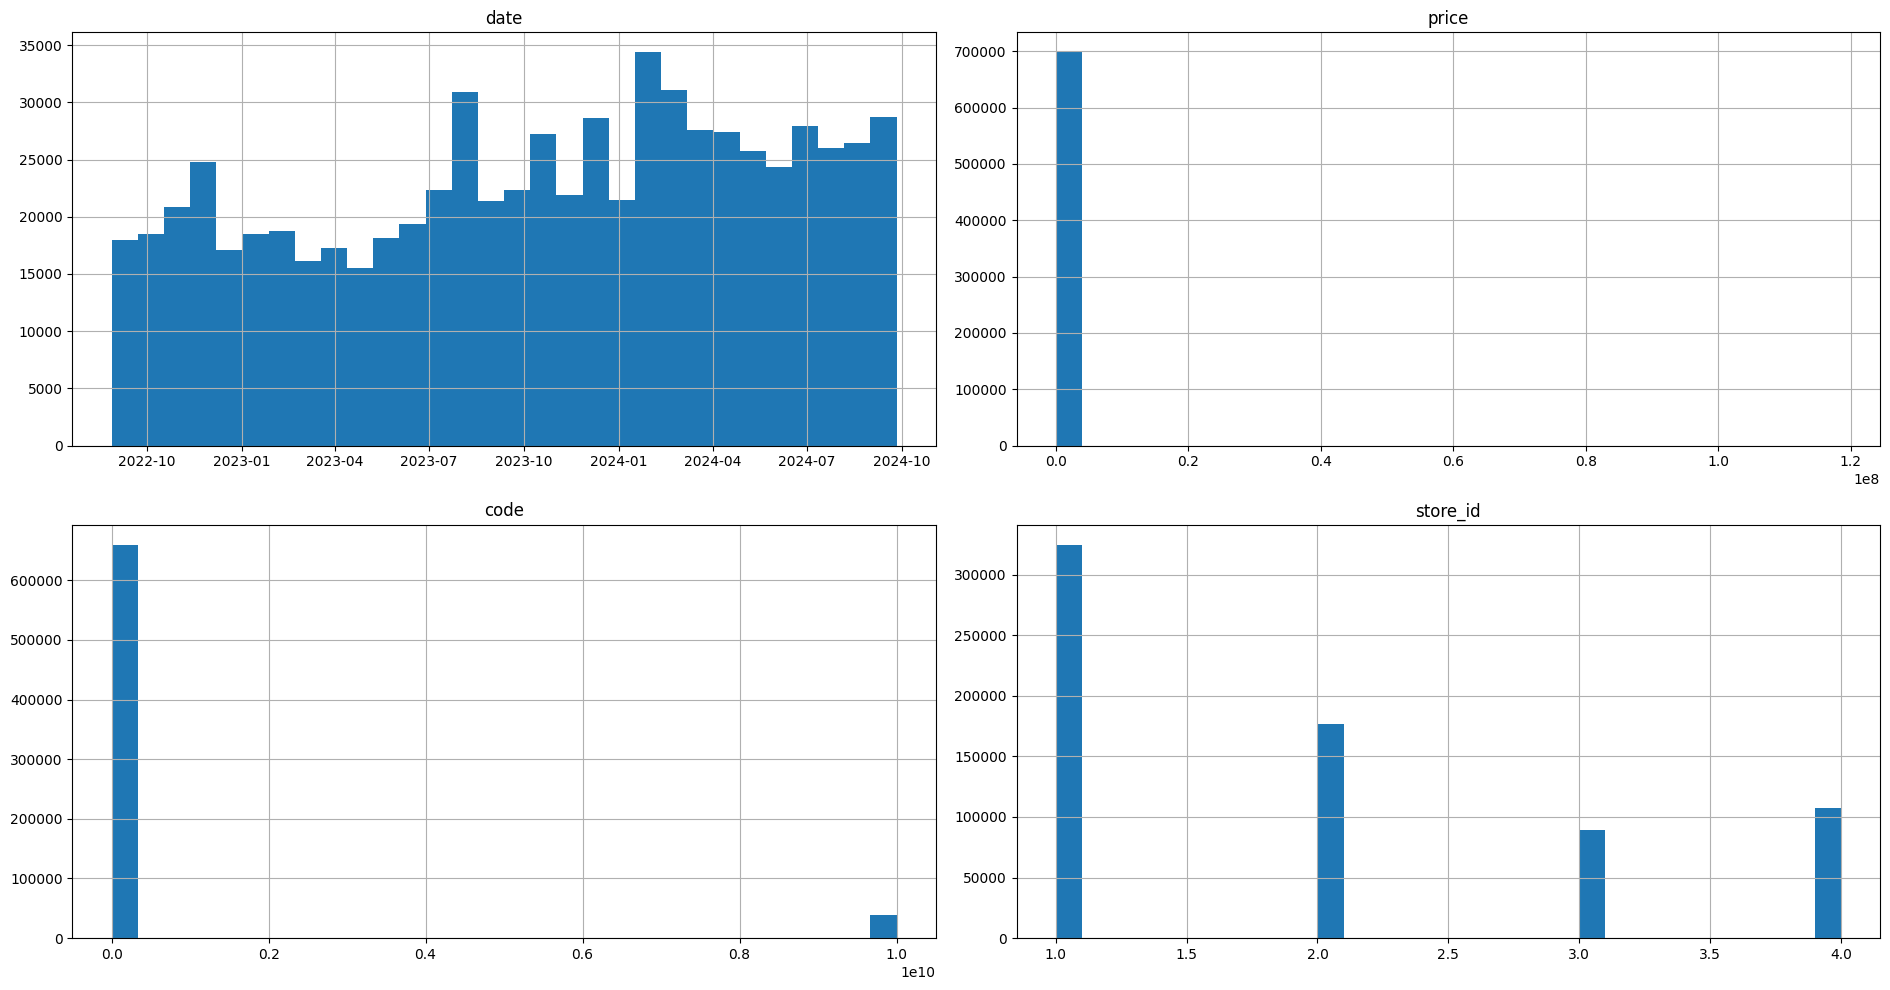

In [97]:
analyze_sales(price_history)

In [98]:
price_history.sort_values('price')

,date,item_id,price,code,store_id
559097,2022-09-21,4940056f9243,0.00,1,3
355189,2023-11-27,48226cc24675,0.00,9999999999,2
355188,2023-11-27,6615d0cbcf25,0.00,9999999999,2
355187,2023-11-27,77847950de3d,0.00,9999999999,2
355186,2023-11-27,fcb9005428b5,0.00,9999999999,2
...,...,...,...,...,...
469668,2023-04-03,2848ba16f5ad,99999.90,1,2
199497,2022-11-11,2848ba16f5ad,159990.00,1,1
430101,2022-09-23,75fe6dc46c61,15690156.40,3,2
211297,2022-12-02,5b77d3454710,118496731.86,1,1


In [99]:
price_history = price_history[price_history['price'] < 50000]

In [100]:
price_history.sort_values('price')

,date,item_id,price,code,store_id
114346,2024-04-29,ee6b1489f4ca,0.00,9999999999,1
684815,2024-08-23,d364011f2de6,0.00,9999999999,4
507988,2023-10-03,df06cb5acc9e,0.00,1,3
62380,2023-12-18,24522d5006f8,0.00,9999999999,1
507997,2023-10-03,ce67cb454fd6,0.00,1,3
...,...,...,...,...,...
516558,2023-11-13,d05fd5de42ad,44990.00,1,3
351351,2023-11-13,d05fd5de42ad,44990.00,1,2
199490,2022-11-11,aac6ad01e1c8,44990.00,1,1
47625,2023-11-13,d05fd5de42ad,44990.00,1,1


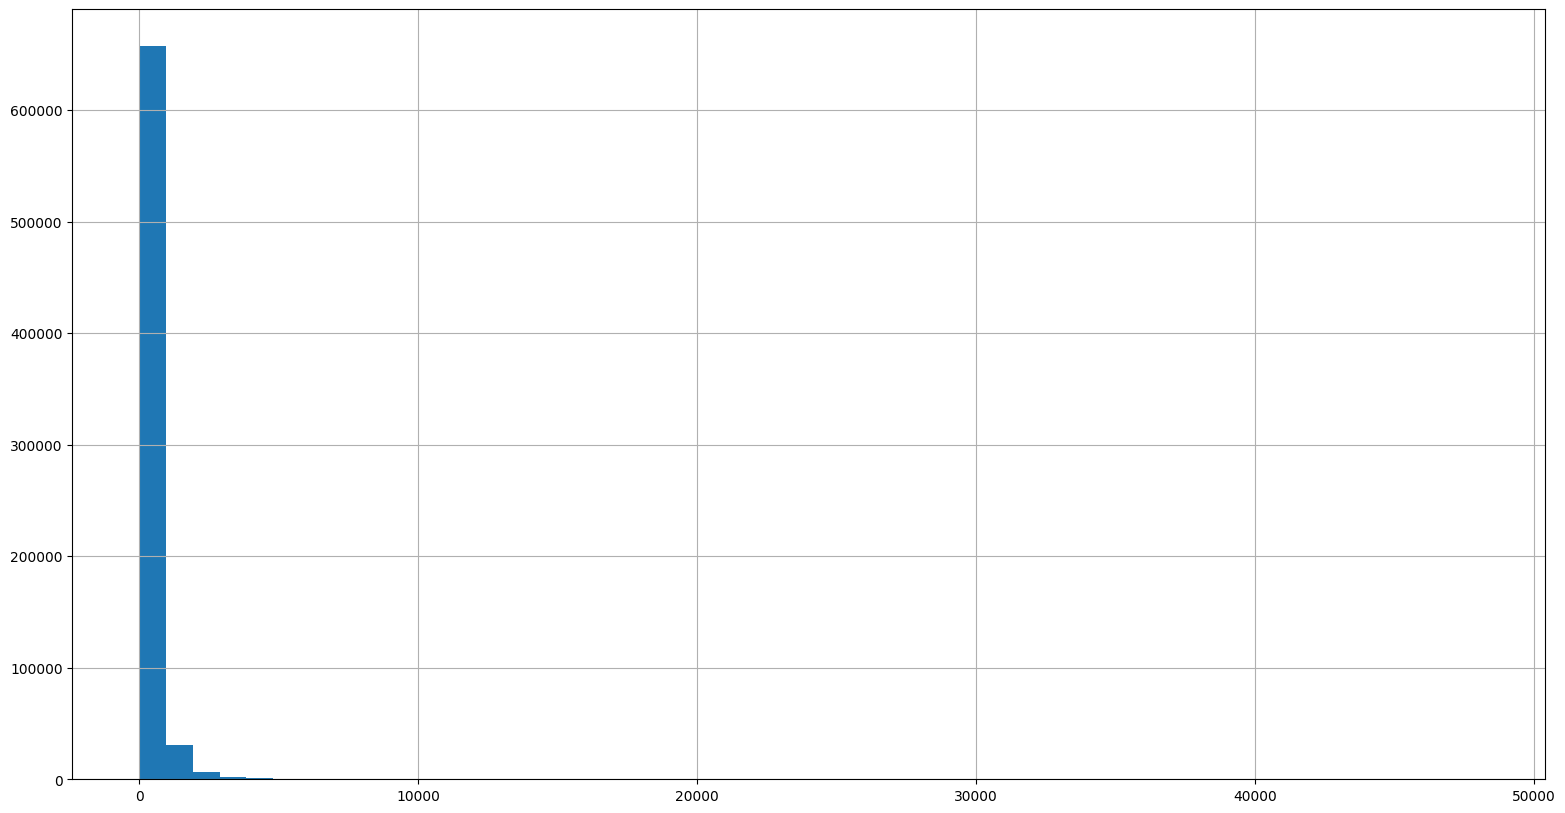

In [101]:
price_history['price'].hist(grid=True, figsize=(19, 10), bins=50);

In [102]:
catalog.query('item_id == "24522d5006f8"')

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
163162,24522d5006f8,СРЕДСТВА ДЛЯ СТИРКИ,ЖИДКИЕ СРЕДСТВА,VFM,Жидкие Средства,1.50,1.50,0.00


Удалим 0 значения

In [103]:
price_history = price_history.query('price != 0')

#### Code

In [104]:
price_history['code'].value_counts().sort_index()

1             175626
2                  2
3              31178
4               5497
6               1623
7              35982
8                  1
9              69130
10             69432
11             24321
12             20320
13             19169
14              7507
18                21
21                 3
22              5555
23             12726
24              3824
25                66
26              2586
27              4507
28                31
29             29948
31             12431
34                45
35             92631
36             10316
41                 3
42                73
43              1601
9999999999       799
Name: code, dtype: int64

In [105]:
price_history.query('code == 9999999999')

,date,item_id,price,code,store_id
92178,2024-02-28,721b5fc17667,489.90,9999999999,1
165049,2024-09-14,eb9eee5a16af,120.00,9999999999,1
172070,2022-08-30,d4bfe0dee415,80.00,9999999999,1
172088,2022-08-30,3e9db75b9838,139.90,9999999999,1
172946,2022-09-02,5e1fa9f1236d,50.00,9999999999,1
...,...,...,...,...,...
562609,2022-10-20,7368a4181d95,67.00,9999999999,3
562610,2022-10-20,4b4435a53fb3,67.00,9999999999,3
562611,2022-10-20,64cf2aa6fbdf,67.00,9999999999,3
562612,2022-10-20,39f3855f98c7,67.00,9999999999,3


In [106]:
price_history = price_history.query('code != 9999999999')

## Статистический анализ

Фильтрация товаров по матрице товаров:
Оставляем только те товары, которые есть в actual_matrix

In [107]:
actual_items = actual_matrix['item_id'].unique()
sales = sales[sales['item_id'].isin(actual_items)]
online = online[online['item_id'].isin(actual_items)]

Агрегация продаж:
Группируем по дате и суммируем столбец sum_total для офлайн и онлайн продаж

In [108]:
sales_agg = sales.groupby('date')['sum_total'].sum().reset_index()
sales_agg = sales_agg.rename(columns={'sum_total': 'offline_sales'})

online_agg = online.groupby('date')['sum_total'].sum().reset_index()
online_agg = online_agg.rename(columns={'sum_total': 'online_sales'})

Объединяем офлайн и онлайн данные по дате

In [109]:
sales_total = pd.merge(sales_agg, online_agg, on='date', how='outer').fillna(0)
sales_total['total_sales'] = sales_total['offline_sales'] + sales_total['online_sales']

sales_total = sales_total.sort_values('date')

In [110]:
sales_total.head()

,date,offline_sales,online_sales,total_sales
0,2022-08-28,2901570.25,162842.00,3064412.25
1,2022-08-29,3349641.53,174272.57,3523914.10
2,2022-08-30,3339880.90,167787.02,3507667.92
3,2022-08-31,3879524.29,218862.13,4098386.42
4,2022-09-01,5037186.06,228133.24,5265319.30


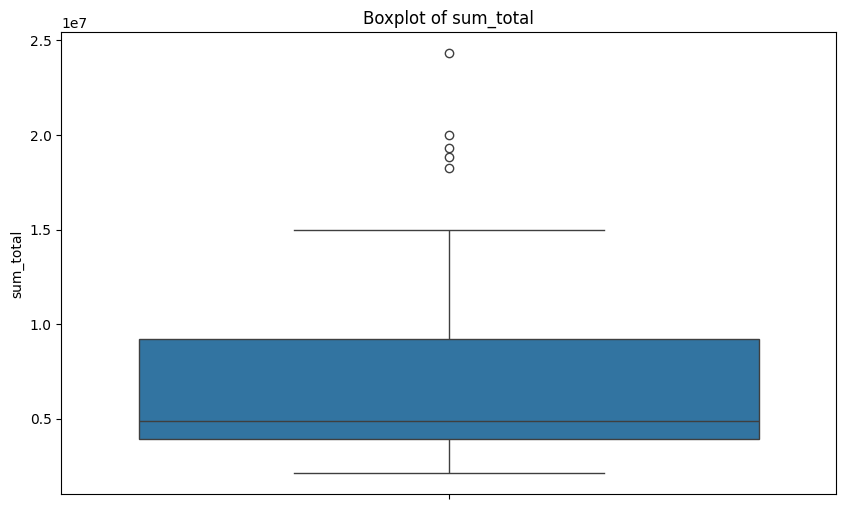

In [111]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=sales_total['total_sales'])
plt.title('Boxplot of sum_total')
plt.ylabel('sum_total')
plt.show()

Посмотрим как выглядят продажи в месяцу по разным годам

In [112]:
monthly_sales = sales_total.set_index('date')
monthly_sales['month'] = monthly_sales.index.month
monthly_sales['year'] = monthly_sales.index.year
month_names = [
    "Январь", "Февраль", "Март", "Апрель", "Май", "Июнь",
    "Июль", "Август", "Сентябрь", "Октябрь", "Ноябрь", "Декабрь"
]
year_colors = {
    2022: 'orange', 
    2023: 'green',  
    2024: 'red'     
}

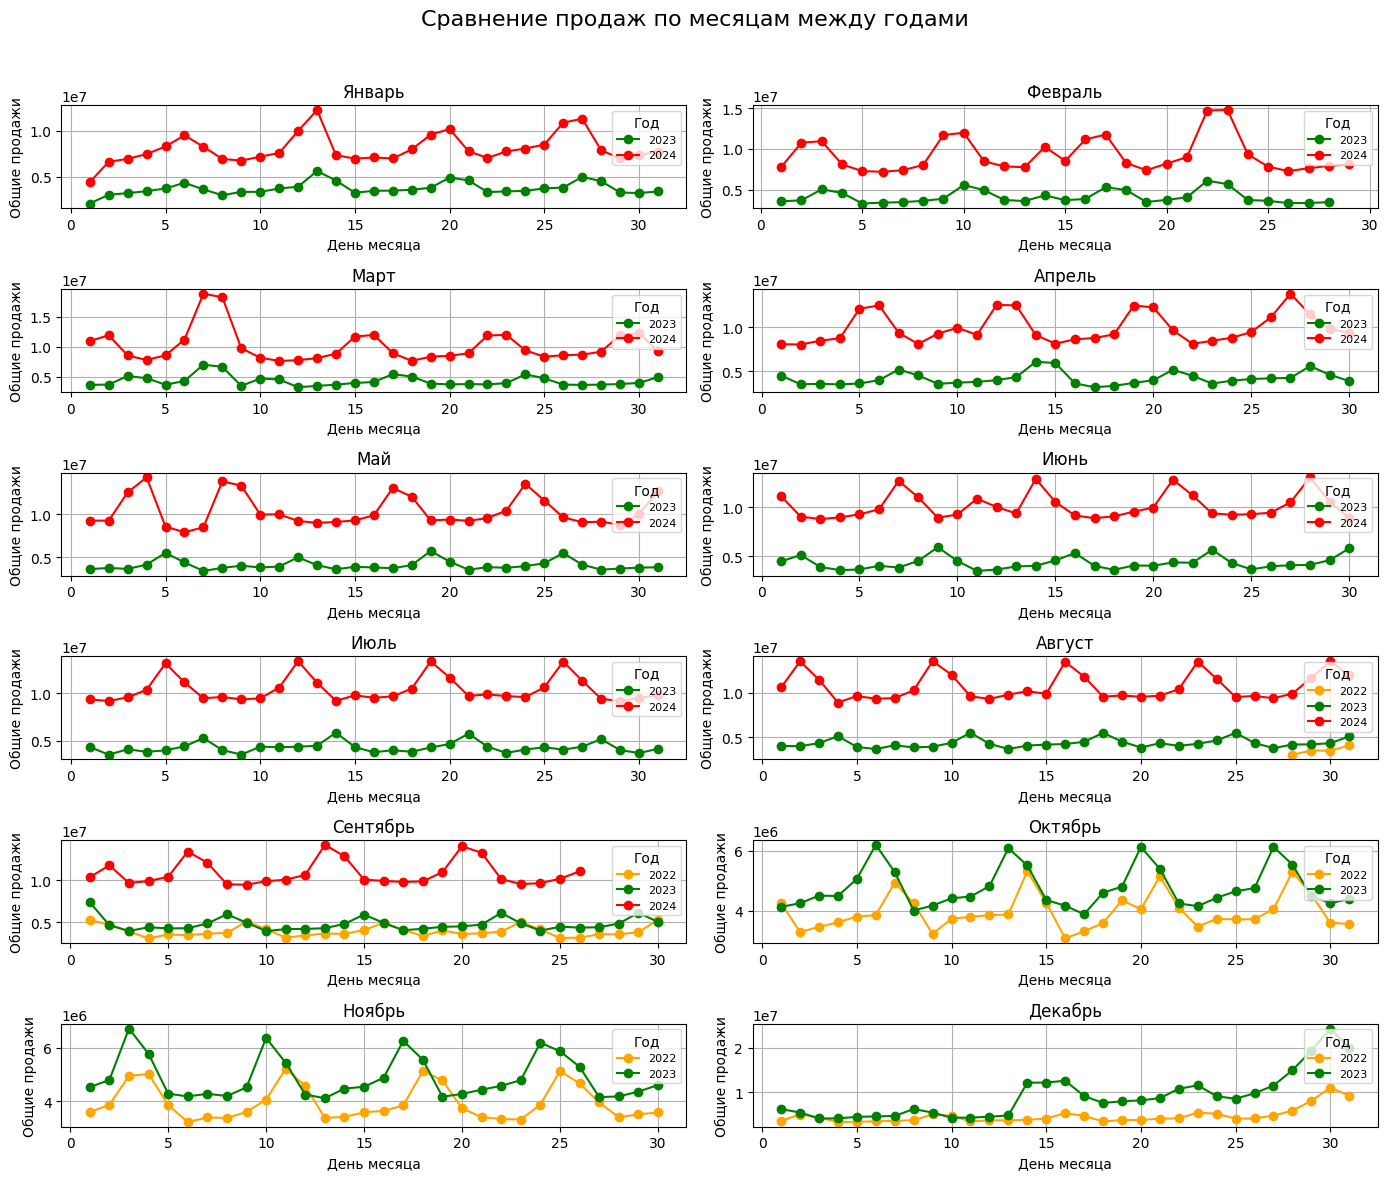

In [113]:
# Создаем пустой график
plt.figure(figsize=(14, 12))

for month in range(1, 13):
    plt.subplot(6, 2, month)
    monthly_data = monthly_sales[monthly_sales['month'] == month]
    
    for year, group in monthly_data.groupby('year'):
        plt.plot(
            group.index.day, 
            group['total_sales'], 
            label=f'{year}', 
            marker='o', 
            color=year_colors.get(year, 'black')
        )
    
    # Добавляем название месяца над графиком
    plt.title(f'{month_names[month - 1]}', fontsize=12)
    plt.xlabel('День месяца')
    plt.ylabel('Общие продажи')
    plt.legend(title='Год', loc='upper right', fontsize=8)
    plt.grid(True)

plt.suptitle('Сравнение продаж по месяцам между годами', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<Figure size 1200x800 with 0 Axes>

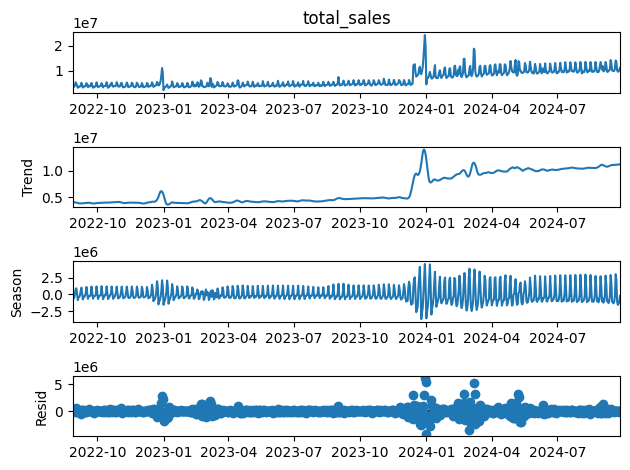

In [114]:
time_series = sales_total.set_index('date')['total_sales']
stl_result = STL(time_series, seasonal=7).fit()

plt.figure(figsize=(12, 8))
stl_result.plot()
plt.tight_layout()
plt.show()

На графике Тренда видны пики, возможно это покупки на новый год. А так же видно что в 24 году произошел скачек цен.Предлагаю использовать данные только за 2024 год, так модель не будет зависима от низких цен в прошлых годах

In [115]:
sales_total = sales_total[sales_total['date'] >= '2024-01-01']
sales_total.head()

,date,offline_sales,online_sales,total_sales
491,2024-01-01,4306250.68,125854.41,4432105.09
492,2024-01-02,6399546.26,220400.43,6619946.69
493,2024-01-03,6646448.82,291374.44,6937823.26
494,2024-01-04,7207986.01,245986.07,7453972.08
495,2024-01-05,7990239.26,290495.35,8280734.61


## Подготовка данных

Добавим новые временные признаки

In [116]:
sales_total['day_of_week'] = sales_total['date'].dt.dayofweek
sales_total['month'] = sales_total['date'].dt.month
#sales_total['year'] = sales_total['date'].dt.year
sales_total['lag_7'] = sales_total['total_sales'].shift(7)
sales_total['lag_14'] = sales_total['total_sales'].shift(14)
sales_total['lag_30'] = sales_total['total_sales'].shift(30)
sales_total['rolling_mean_7'] = sales_total['total_sales'].rolling(window=7).mean()
sales_total['rolling_mean_14'] = sales_total['total_sales'].rolling(window=14).mean()
sales_total['expanding_mean'] = sales_total['total_sales'].expanding().mean()
sales_total = sales_total.dropna()

interval columns not set, guessing: ['offline_sales', 'online_sales', 'total_sales', 'day_of_week', 'month', 'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_mean_14', 'expanding_mean']


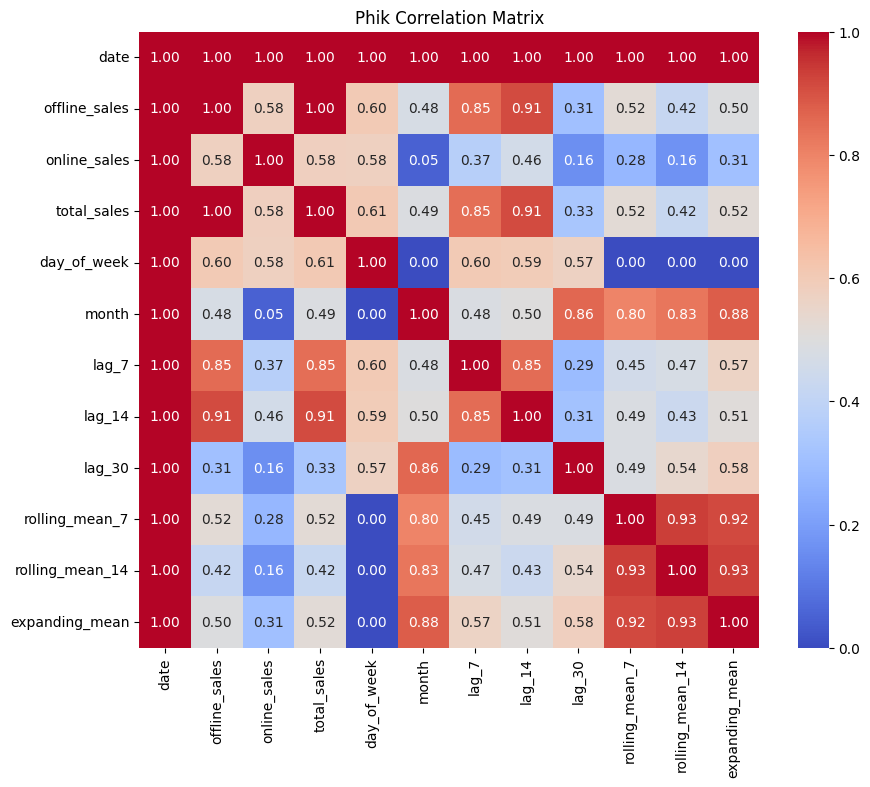

In [117]:
phik_matrix = sales_total.phik_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Phik Correlation Matrix')
plt.show()

 Корреляционный анализ
* total_sales имеет очень высокую корреляцию с offline_sales (1.00) и среднюю с online_sales (0.58). Это ожидаемо, так как total_sales = offline_sales + online_sales.
* total_sales также сильно коррелирует с лагами (lag_7: 0.85, lag_14: 0.91), что указывает на временную зависимость.
* rolling_mean_7 и rolling_mean_14 коррелируют с total_sales на 0.52 и 0.42 соответственно, что говорит о полезности скользящих средних в прогнозировании.
* expanding_mean коррелирует с total_sales на 0.52, что подтверждает трендовую составляющую.
  
Значимость временных признаков
* day_of_week имеет слабую корреляцию с total_sales (0.61), что может указывать на закономерности продаж в зависимости от дня недели.
* month имеет слабую, но заметную корреляцию с total_sales (0.49), что может свидетельствовать о сезонности.
  
Выводы
* Основные драйверы total_sales: offline_sales, online_sales, lag_7, lag_14, rolling_mean_7, expanding_mean.
* Временные тренды: Явно выраженные, особенно недельные (lag_7, lag_14), что можно использовать в моделях.
* Сезонность: Месячная (month) влияет умеренно, недельная (day_of_week) заметна, но не доминирует.

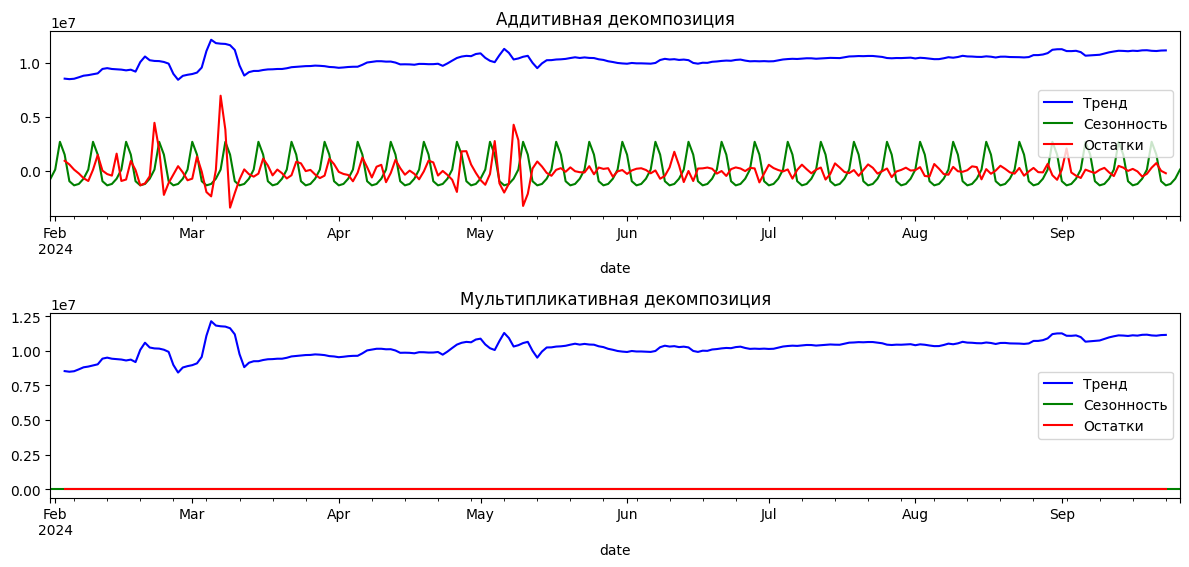

In [118]:
time_series = sales_total.set_index('date')['total_sales']

result_additive = seasonal_decompose(time_series, model='additive', period=7) 
result_multiplicative = seasonal_decompose(time_series, model='multiplicative', period=7)

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.title("Аддитивная декомпозиция")
result_additive.trend.plot(label='Тренд', color='blue')
result_additive.seasonal.plot(label='Сезонность', color='green')
result_additive.resid.plot(label='Остатки', color='red')
plt.legend()

plt.subplot(3, 1, 2)
plt.title("Мультипликативная декомпозиция")
result_multiplicative.trend.plot(label='Тренд', color='blue')
result_multiplicative.seasonal.plot(label='Сезонность', color='green')
result_multiplicative.resid.plot(label='Остатки', color='red')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

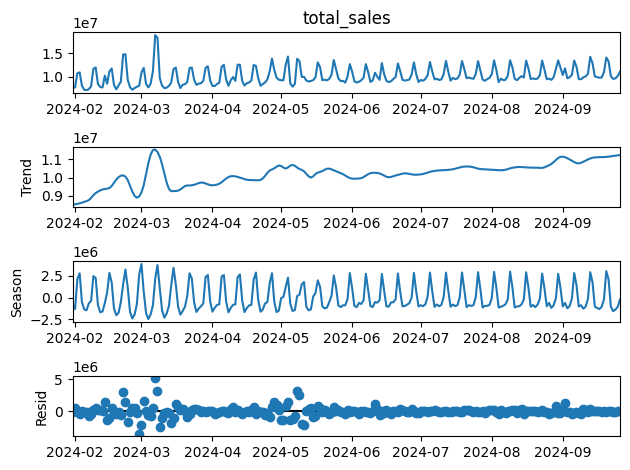

In [119]:
stl_result = STL(time_series, seasonal=7).fit()

plt.figure(figsize=(12, 8))
stl_result.plot()
plt.tight_layout()
plt.show()

Виден восходящий тренд, а так же сезонность в данных

In [120]:
train = sales_total[sales_total['date'] < '2024-09-01']
test = sales_total[sales_total['date'] >= '2024-09-01']

X_train = train[['day_of_week', 'month', 'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_mean_14', 'expanding_mean']]
y_train = train['total_sales']
X_test = test[['day_of_week', 'month', 'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_mean_14', 'expanding_mean']]
y_test = test['total_sales']

## Модели для Прогноз

### STL-декомпозиция и линейная регрессия

RMSE: 628014.22
MAPE: 3.67%


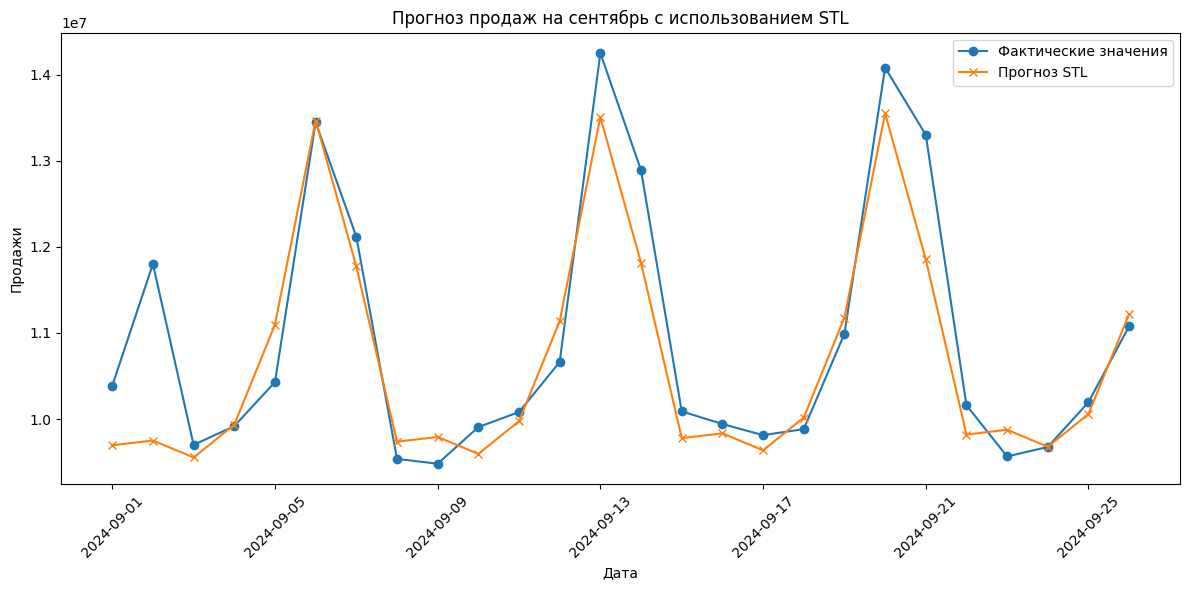

In [121]:
time_series_train = train.set_index('date')['total_sales']
time_series_test = test.set_index('date')['total_sales']
# STL-декомпозиция для тренировочных данных
stl_train = STL(time_series_train, seasonal=7).fit()
trend_train = stl_train.trend.dropna()
seasonal_train = stl_train.seasonal.dropna()
# Модель для тренда
X_trend = np.arange(len(trend_train)).reshape(-1, 1)
y_trend = trend_train.values
trend_model = LinearRegression().fit(X_trend, y_trend)
# Прогноз тренда
X_trend_future = np.arange(len(time_series_train), len(time_series_train) + len(time_series_test)).reshape(-1, 1)
trend_forecast = trend_model.predict(X_trend_future)
# Сезонность повторяется циклически
seasonal_cycle = seasonal_train[-7:].values  # Последний сезонный цикл
seasonal_forecast = np.tile(seasonal_cycle, int(np.ceil(len(time_series_test) / 7)))[:len(time_series_test)]
# Итоговый прогноз
forecast = trend_forecast + seasonal_forecast
# Оценка качества прогноза
rmse = np.sqrt(mean_squared_error(time_series_test, forecast))
mape = mean_absolute_percentage_error(time_series_test, forecast) * 100  # MAPE в процентах

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(time_series_test.index, time_series_test, label='Фактические значения', marker='o')
plt.plot(time_series_test.index, forecast, label='Прогноз STL', marker='x')
plt.title('Прогноз продаж на сентябрь с использованием STL')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Использование SARIMA и CatBoost

Подбор гиперпараметров SARIMA с помощью AutoARIMA...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=6668.571, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=6780.339, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=6731.058, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=6754.604, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6778.363, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=6741.702, Time=0.11 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=6663.177, Time=0.25 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=6662.476, Time=0.19 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=6684.014, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=6684.417, Time=0.06 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=6625.942, Time=0.19 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=6658.785, Time=0.11 sec
 ARIMA(2,1,1)(2,0,1)[7] intercept   : AIC=6627.724,

C:\Users\dinos\anaconda3\envs\practicum\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dinos\AppData\Local\Temp\ipykernel_11760\443238654.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'residuals'] = time_series_test.values - sarima_test_pred.values


0:	learn: 1289386.4109649	total: 143ms	remaining: 14.1s
99:	learn: 855248.3743166	total: 219ms	remaining: 0us
RMSE: 798521.10
MAPE: 5.13%


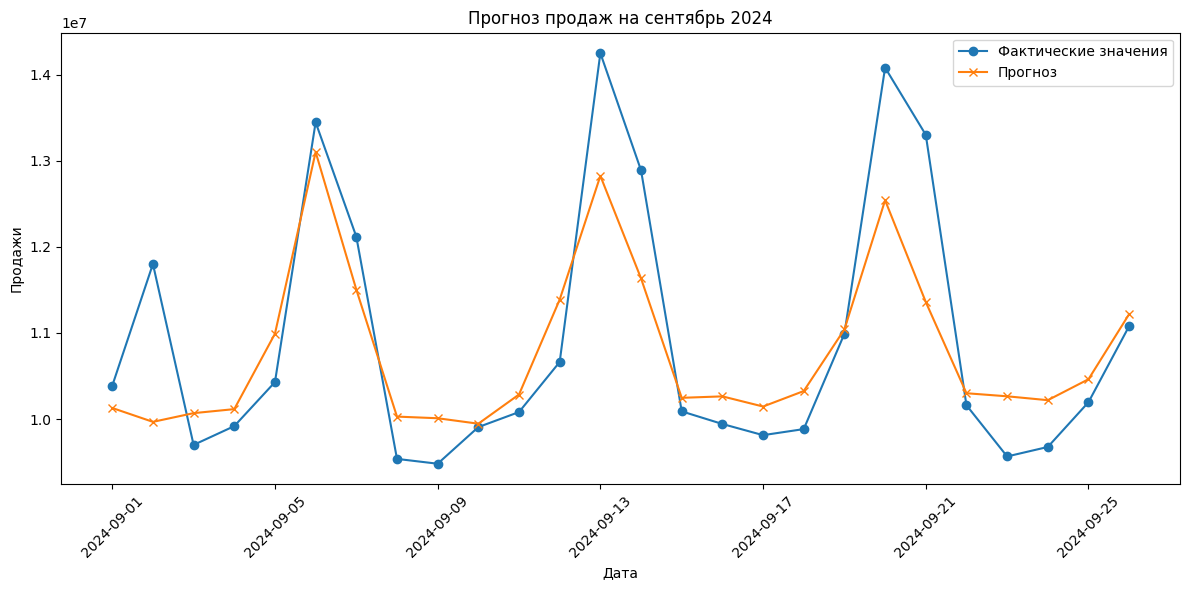

In [122]:
time_series_train = train.set_index('date')['total_sales'].asfreq('D')
time_series_test = test.set_index('date')['total_sales'].asfreq('D')

print("Подбор гиперпараметров SARIMA с помощью AutoARIMA...")
model_autoarima = auto_arima(
    time_series_train,
    start_p=1, max_p=3,
    start_q=1, max_q=3,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    m=7, 
    seasonal=True,
    trace=True, 
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Вывод лучших параметров
best_order = model_autoarima.order
best_seasonal_order = model_autoarima.seasonal_order
print(f"Лучшие параметры SARIMA: Order={best_order}, Seasonal_Order={best_seasonal_order}")

# Обучение SARIMA с оптимальными параметрами
model_sarima = SARIMAX(
    time_series_train,
    order=best_order,
    seasonal_order=best_seasonal_order
)
sarima_fit = model_sarima.fit(disp=False)

# Прогноз SARIMA для тестового периода
sarima_forecast = sarima_fit.get_forecast(steps=len(time_series_test))
sarima_test_pred = sarima_forecast.predicted_mean

test.loc[:, 'residuals'] = time_series_test.values - sarima_test_pred.values

# Получение предсказаний SARIMA для тренировочного периода
sarima_train_pred = sarima_fit.get_prediction(start=time_series_train.index[0], end=time_series_train.index[-1])
predicted_train = sarima_train_pred.predicted_mean

# Подготовка данных для CatBoost
X_train_CatBoost = train[['day_of_week', 'month','lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_mean_14', 'expanding_mean']]
y_train_CatBoost = train['total_sales'] - predicted_train.values

X_test_CatBoost = test[['day_of_week', 'month', 'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_mean_14', 'expanding_mean']]
y_test_CatBoost = test['total_sales']

# Обучение CatBoost
model_catboost = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    verbose=100
)
model_catboost.fit(X_train_CatBoost, y_train_CatBoost)

catboost_forecast = model_catboost.predict(X_test_CatBoost)
final_forecast = sarima_test_pred.values + catboost_forecast

rmse = np.sqrt(mean_squared_error(y_test, final_forecast))
mape = mean_absolute_percentage_error(y_test_CatBoost, final_forecast) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(test['date'], y_test, label='Фактические значения', marker='o')
plt.plot(test['date'], final_forecast, label='Прогноз', marker='x')
plt.title('Прогноз продаж на сентябрь 2024')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### CatBoostRegressor

In [123]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_pool = Pool(X_train_scaled, y_train)
test_pool = Pool(X_test_scaled, y_test)

param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5],
    'random_strength': [1, 1.5, 2]
}

model = CatBoostRegressor(loss_function='RMSE', verbose=200)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

0:	learn: 1840458.1672768	total: 1.16ms	remaining: 230ms
199:	learn: 517142.7863317	total: 195ms	remaining: 0us


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001D801C3D7F0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [100, 200],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'random_strength': [1, 1.5, 2]},
             scoring='neg_root_mean_squared_error')

Лучшие параметры: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'random_strength': 2}
0:	learn: 1840458.1672768	test: 1631515.8754654	best: 1631515.8754654 (0)	total: 1.16ms	remaining: 232ms
199:	learn: 517142.7863317	test: 934371.5092721	best: 772558.6951917 (103)	total: 199ms	remaining: 0us

bestTest = 772558.6952
bestIteration = 103

Shrink model to first 104 iterations.
RMSE: 772558.76
MAE: 652141.99
MAPE: 5.83%


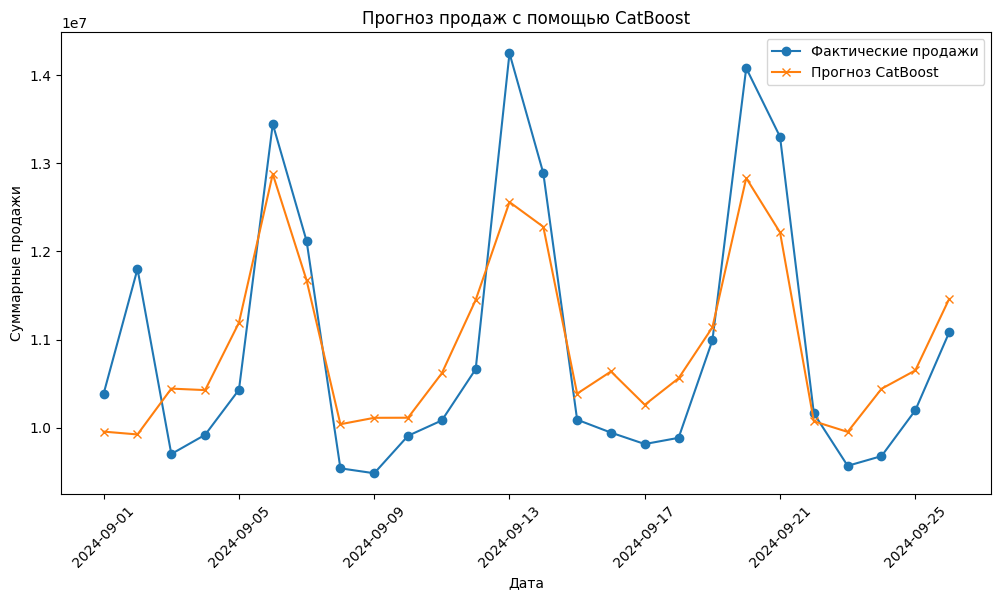

In [124]:
print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

forecast = best_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, forecast))
mae = mean_absolute_error(y_test, forecast)
mape = mean_absolute_percentage_error(y_test, forecast) * 100
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(test['date'], y_test, label='Фактические продажи', marker='o')
plt.plot(test['date'], forecast, label='Прогноз CatBoost', marker='x')
plt.title('Прогноз продаж с помощью CatBoost')
plt.xlabel('Дата')
plt.ylabel('Суммарные продажи')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### STL-декомпозиция и Catboost

RMSE: 586383.86
MAPE: 3.59%


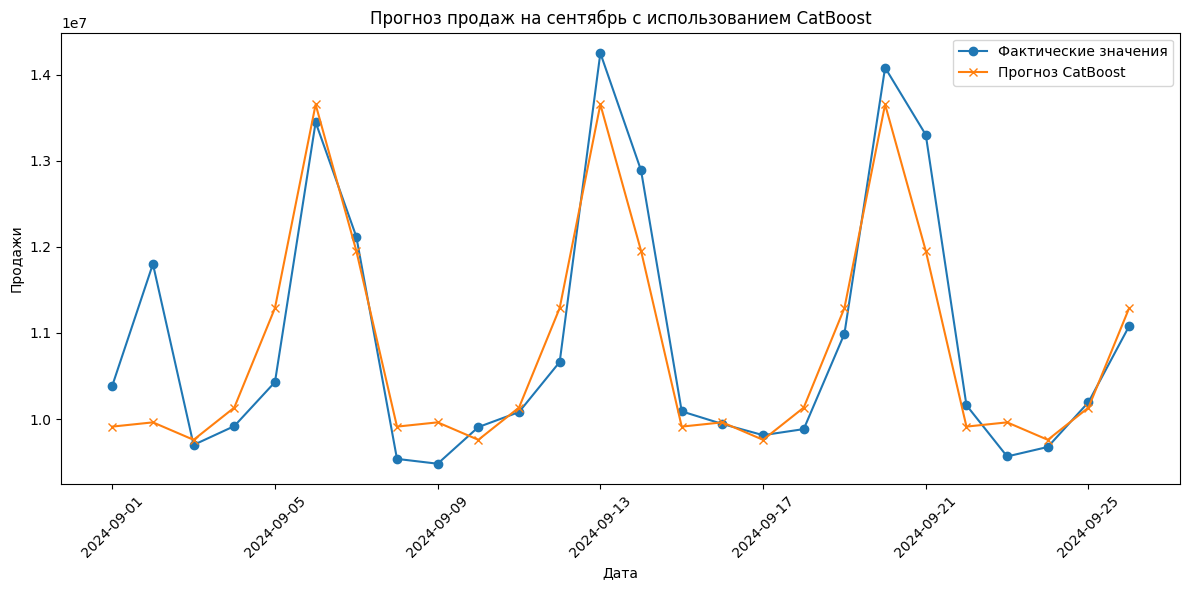

In [125]:
time_series_train = train.set_index('date')['total_sales']
time_series_test = test.set_index('date')['total_sales']

# STL-декомпозиция для тренировочных данных
stl_train = STL(time_series_train, seasonal=7).fit()
trend_train = stl_train.trend.dropna()
seasonal_train = stl_train.seasonal.dropna()

# Подготовка данных для CatBoost
X_train = np.arange(len(trend_train)).reshape(-1, 1)
y_train = trend_train.values

X_test = np.arange(len(trend_train), len(trend_train) + len(time_series_test)).reshape(-1, 1)

# Обучение модели CatBoost
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0)
model.fit(X_train, y_train)

trend_forecast = model.predict(X_test)

seasonal_cycle = seasonal_train[-7:].values
seasonal_forecast = np.tile(seasonal_cycle, int(np.ceil(len(time_series_test) / 7)))[:len(time_series_test)]

# Итоговый прогноз
forecast = trend_forecast + seasonal_forecast

rmse = np.sqrt(mean_squared_error(time_series_test, forecast))
mape = mean_absolute_percentage_error(time_series_test, forecast) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(time_series_test.index, time_series_test, label='Фактические значения', marker='o')
plt.plot(time_series_test.index, forecast, label='Прогноз CatBoost', marker='x')
plt.title('Прогноз продаж на сентябрь с использованием CatBoost')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### STL-декомпозиция и Catboost(GridSearchCV)

Лучшие параметры: {'depth': 8, 'iterations': 1000, 'learning_rate': 0.2, 'loss_function': 'RMSE'}
RMSE: 585558.67
MAPE: 3.59%


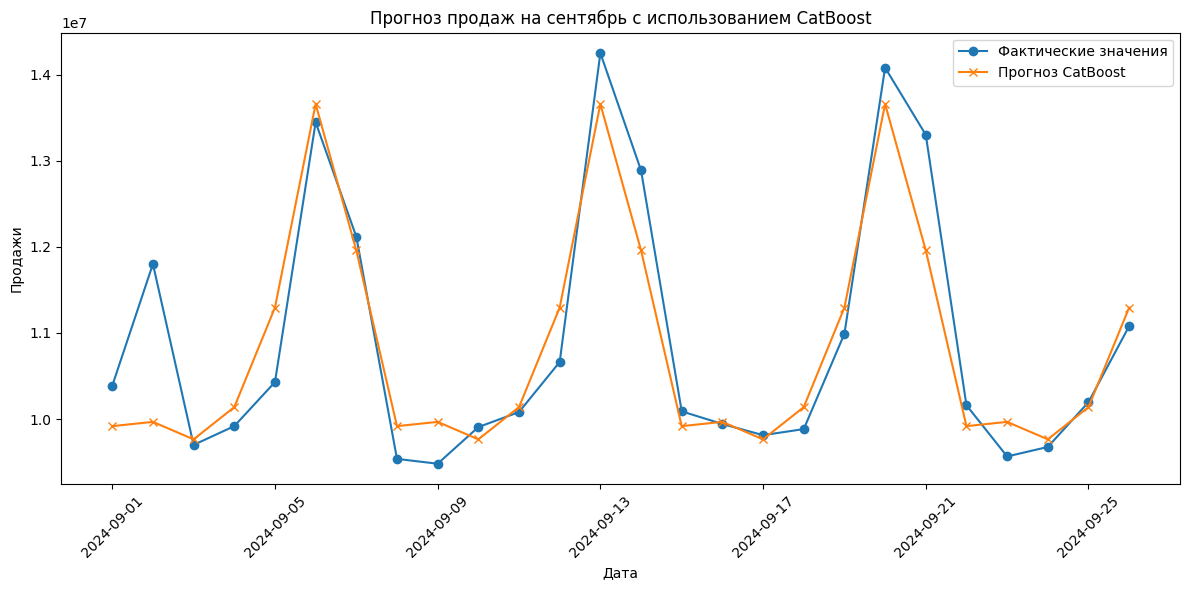

In [126]:
time_series_train = train.set_index('date')['total_sales']
time_series_test = test.set_index('date')['total_sales']

stl_train = STL(time_series_train, seasonal=7).fit()
trend_train = stl_train.trend.dropna()
seasonal_train = stl_train.seasonal.dropna()

# Подготовка данных для CatBoost
X_train = np.arange(len(trend_train)).reshape(-1, 1)
y_train = trend_train.values

X_test = np.arange(len(trend_train), len(trend_train) + len(time_series_test)).reshape(-1, 1)

# Гиперпараметры для перебора
param_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'loss_function': ['RMSE']
}

best_model = None
best_rmse = float('inf')

# Перебор гиперпараметров
for params in ParameterGrid(param_grid):
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train)
    
    trend_forecast = model.predict(X_test)
    
    seasonal_cycle = seasonal_train[-7:].values
    seasonal_forecast = np.tile(seasonal_cycle, int(np.ceil(len(time_series_test) / 7)))[:len(time_series_test)]
    
    # Итоговый прогноз
    forecast = trend_forecast + seasonal_forecast

    rmse = np.sqrt(mean_squared_error(time_series_test, forecast))
    mape = mean_absolute_percentage_error(time_series_test, forecast) * 100
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_forecast = forecast
        best_params = params

print(f"Лучшие параметры: {best_params}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(time_series_test.index, time_series_test, label='Фактические значения', marker='o')
plt.plot(time_series_test.index, best_forecast, label='Прогноз CatBoost', marker='x')
plt.title('Прогноз продаж на сентябрь с использованием CatBoost')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Посмотрим метрики качества на лучшей модели

In [127]:
rmse = np.sqrt(mean_squared_error(time_series_test, forecast))
mape = mean_absolute_percentage_error(time_series_test, forecast) * 100
mae = mean_absolute_error(test['total_sales'], forecast)
msle = mean_squared_error(np.log1p(test['total_sales']), np.log1p(forecast))
r2 = r2_score(test['total_sales'], forecast)
smape = 100 * np.mean(2 * np.abs(test['total_sales'] - forecast) / (np.abs(test['total_sales']) + np.abs(forecast)))

naive_forecast = test['total_sales'].shift(1).fillna(method='bfill')
mase = mean_absolute_error(test['total_sales'], forecast) / mean_absolute_error(test['total_sales'], naive_forecast)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'SMAPE: {smape:.2f}%')
print(f'MSLE: {msle:.2f}')
print(f'R^2: {r2:.2f}')
print(f'MASE: {mase:.2f}')

RMSE: 585558.67
MAE: 408245.08
MAPE: 3.59%
SMAPE: 3.65%
MSLE: 0.00
R^2: 0.84
MASE: 0.35


## Использование лучшей модели для прогноза

Лучшая модель STL-декомпозиция и Catboost(GridSearchCV), используем ее для предсказание следующей недели

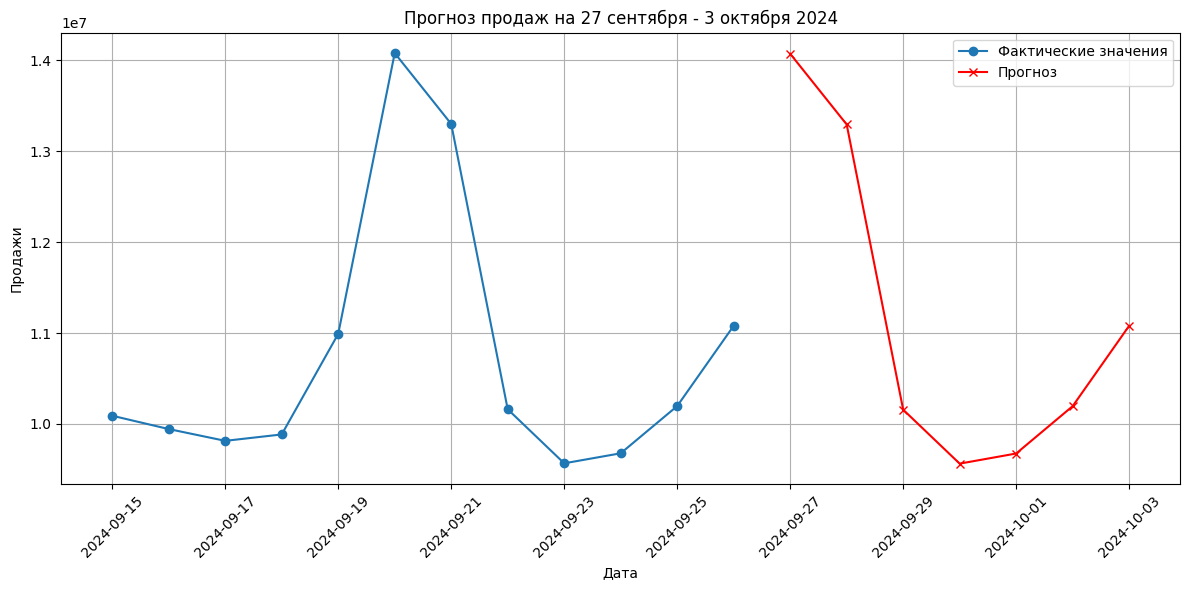

            predicted_sales
date                       
2024-09-27      14074024.35
2024-09-28      13295453.31
2024-09-29      10156459.83
2024-09-30       9562794.29
2024-10-01       9674307.89
2024-10-02      10195216.15
2024-10-03      11080061.88


In [128]:
sales_total = sales_total[(sales_total['date'] >= '2024-09-01') & (sales_total['date'] <= '2024-09-26')]

# Пересчет фичей с учетом нового временного окна
sales_total['lag_7'] = sales_total['total_sales'].shift(7)
sales_total['lag_14'] = sales_total['total_sales'].shift(14)
sales_total['rolling_mean_7'] = sales_total['total_sales'].rolling(window=7).mean()
sales_total['rolling_mean_14'] = sales_total['total_sales'].rolling(window=14).mean()
sales_total['expanding_mean'] = sales_total['total_sales'].expanding().mean()

sales_total = sales_total.dropna()

time_series = sales_total.set_index('date')['total_sales']
stl = STL(time_series, seasonal=7).fit()
trend = stl.trend
seasonal = stl.seasonal

X = np.arange(len(trend)).reshape(-1, 1)
y = trend.values

# Параметры модели (используем ранее найденные лучшие параметры)
best_params = {
    'iterations': 1000,
    'depth': 6,
    'learning_rate': 0.1,
    'loss_function': 'RMSE',
    'verbose': 0
}

# Обучение модели
model = CatBoostRegressor(**best_params)
model.fit(X, y)

future_days = 7
X_future = np.arange(len(trend), len(trend) + future_days).reshape(-1, 1)
trend_forecast = model.predict(X_future)

# Сезонная компонента (повтор последней недели)
seasonal_forecast = np.tile(seasonal[-7:].values, 2)[:future_days]

# Итоговый прогноз
forecast_dates = pd.date_range('2024-09-27', periods=future_days)
final_forecast = pd.DataFrame({
    'date': forecast_dates,
    'predicted_sales': trend_forecast + seasonal_forecast
})

plt.figure(figsize=(12, 6))
plt.plot(time_series.index, time_series, label='Фактические значения', marker='o')
plt.plot(final_forecast['date'], final_forecast['predicted_sales'], 
         label='Прогноз', marker='x', color='red')
plt.title('Прогноз продаж на 27 сентября - 3 октября 2024')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

print(final_forecast.set_index('date'))

## Вывод

В ходе работы над исследованием была обучена, выбрана и протестирована лучшая модель машинного обучения STL-декомпозиция вместе с Catboost(GridSearchCV), Прогнозирующее временной рыд на следющию неделю.  Качество модели на тестовой выборке: 
* MAPE: 3.59%,
* SMAPE: 3.65%,
* MSLE: 0.00,
* R^2: 0.84,
* MASE: 0.35

**Что можно улучшить?**
* Включить дополнительные признаки: скидки, календарные эффекты (праздники, выходные).
* Использовать другие связки моделей с ARIMA или SARIMA
* Использование нейросети таких как LSTM, CNN + LSTM
* Так-же стоить уточнить насчет товаров с препиской "НЕ ИСПОЛЬЗОВАТЬ"

In [129]:
catalog[catalog['dept_name'].str.contains('НЕ ИСПОЛЬЗОВАТЬ', na=False)].head()

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
1292,15b716487be1,СДОБНЫЕ ИЗДЕЛИЯ(НЕ ИСПОЛЬЗОВАТЬ),СЛОЙКА,СОБСТВЕННОЕ ПРОИЗВОДСТВО,N/A,0.07,0.07,0.00
4450,ed772090dd0d,РЫБА СВЕЖАЯ НЕ ИСПОЛЬЗОВАТЬ,РЫБА СВЕЖАЯ,МОРЕПРОДУКТЫ СВЕЖИЕ,Морепродукты,0.00,0.10,0.00
4451,3ceca586ddd4,РЫБА СВЕЖАЯ НЕ ИСПОЛЬЗОВАТЬ,РЫБА СВЕЖАЯ,МОРЕПРОДУКТЫ СВЕЖИЕ,Морепродукты,0.20,0.12,0.00
4453,732733391a4e,РЫБА СВЕЖАЯ НЕ ИСПОЛЬЗОВАТЬ,РЫБА СВЕЖАЯ,МОРЕПРОДУКТЫ СВЕЖИЕ,Свежая,0.00,0.18,0.00
6566,95675c1043f2,РЫБА СВЕЖАЯ НЕ ИСПОЛЬЗОВАТЬ,РЫБА СВЕЖАЯ,МОРЕПРОДУКТЫ СВЕЖИЕ,Морепродукты,0.00,0.18,0.00
